# Detailed analysis of lysine deserts in the reference human proteome from the UniProt database 

# 1. Import libraries

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import re
import pickle
import os
import math
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 600
import seaborn as sns
from scipy.stats import fisher_exact, spearmanr, mannwhitneyu
from collections import Counter
from Bio import SeqIO
from ipywidgets import Text, HBox, Label
from IPython.display import display
import statistics
from Bio.PDB import PDBParser
parser = PDBParser(PERMISSIVE=1)
from Bio.PDB.DSSP import DSSP

# 2. Read preprocessed data

Read preprocessed data obtained by running `Download_data.ipynb`.

In [2]:
# Read human proteome file
df = pd.read_csv('data/Uniprot_human_proteome.tsv.gz', sep='\t')

# Create dict Gene Symbol : E3 ligase class
ligase_dict = {}
df_ligase = pd.read_csv('data/E3_list.tsv', sep='\t')
for ident, value in df_ligase.iterrows():
    ligase_dict[value[0].upper()] = value[1]
   
# Create dict Uniprot ID : Gene Symbol
uni_id_to_gene = {}
for ident, value in df.iterrows():
        if isinstance(value[3], str):
            gene = value[3].split(' ')[0].upper()
        else:
            gene = None
        uni_id_to_gene[value[0]] = gene 
        
# Create list of Housekeeping Genes
f = open('data/HK_genes.txt')
lines = f.readlines()
f.close()

hk_list = []
for line in lines:
    hk_list.append(line.split('\t')[0].strip())

In [3]:
df.head(5)

Entry  Reviewed   Entry Name  \
0  A0A087X1C5  reviewed  CP2D7_HUMAN   
1  A0A0B4J2F0  reviewed  PIOS1_HUMAN   
2  A0A0B4J2F2  reviewed  SIK1B_HUMAN   
3  A0A0C5B5G6  reviewed  MOTSC_HUMAN   
4  A0A0K2S4Q6  reviewed  CD3CH_HUMAN   

                                       Protein names Gene Names  \
0        Putative cytochrome P450 2D7 (EC 1.14.14.1)     CYP2D7   
1   Protein PIGBOS1 (PIGB opposite strand protein 1)    PIGBOS1   
2  Putative serine/threonine-protein kinase SIK1B...      SIK1B   
3  Mitochondrial-derived peptide MOTS-c (Mitochon...    MT-RNR1   
4  Protein CD300H (CD300 antigen-like family memb...     CD300H   

               Organism  Length                   Proteomes  \
0  Homo sapiens (Human)   515.0  UP000005640: Chromosome 22   
1  Homo sapiens (Human)    54.0  UP000005640: Chromosome 15   
2  Homo sapiens (Human)   783.0  UP000005640: Chromosome 21   
3  Homo sapiens (Human)    16.0  UP000005640: Mitochondrion   
4  Homo sapiens (Human)   201.0  UP000005640: Chromosome 17   

                           Subcellular location [CC]  \
0  SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...   
1  SUBCELLULAR LOCATION: Mitochondrion outer memb...   
2                                                NaN   
3  SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...   
4  SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...   

                  Gene Ontology (biological process)  \
0  arachidonic acid metabolic process [GO:0019369...   
1  regulation of endoplasmic reticulum unfolded p...   
2  cellular response to glucose starvation [GO:00...   
3  activation of protein kinase activity [GO:0032...   
4                 neutrophil chemotaxis [GO:0030593]   

                  Gene Ontology (cellular component)  \
0  cytoplasm [GO:0005737]; integral component of ...   
1  integral component of mitochondrial outer memb...   
2                             cytoplasm [GO:0005737]   
3  extracellular space [GO:0005615]; mitochondrio...   
4  extracellular region [GO:0005576]; integral co...   

                  Gene Ontology (molecular function)  \
0  aromatase activity [GO:0070330]; heme binding ...   
1                                                NaN   
2  ATP binding [GO:0005524]; magnesium ion bindin...   
3  DNA binding [GO:0003677]; DNA-binding transcri...   
4  transmembrane signaling receptor activity [GO:...   

                                            Sequence  \
0  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...   
1  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...   
2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...   
3                                   MRWQEMGYIFYPRKLR   
4  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...   

                                       Function [CC]  \
0  FUNCTION: May be responsible for the metabolis...   
1  FUNCTION: Plays a role in regulation of the un...   
2  FUNCTION: Probable serine/threonine-protein ki...   
3  FUNCTION: Regulates insulin sensitivity and me...   
4  FUNCTION: May play an important role in innate...   

                                  Tissue specificity Pathway  \
0  TISSUE SPECIFICITY: Expressed in brain cortex ...     NaN   
1                                                NaN     NaN   
2                                                NaN     NaN   
3  TISSUE SPECIFICITY: Detected in plasma (at pro...     NaN   
4  TISSUE SPECIFICITY: Expressed on CD16+ monocyt...     NaN   

  Involvement in disease                                    Natural variant  \
0                    NaN  VARIANT 70; /note="S -> N (in dbSNP:rs11090077...   
1                    NaN                                                NaN   
2                    NaN                                                NaN   
3                    NaN  VARIANT 14; /note="K -> Q (specific to the Nor...   
4                    NaN                                                NaN   

                                    Protein families  \
0                             Cytochrome P450 f

# 3. Set parameters

In [4]:
# Define lysine desert region minimum length; integer or float
desert_min_lengths = [150, 0.5]
# Define minimum sequence length
seq_min_length = 150
# Define maximum number of predicted Transmembrane Helices (TMH) in sequence
TMH_max = 2.0

########################################### LYSINE CLUSTER ##########################################
# Define minimum fraction of total sequence lysines to be in close proximity to form lysine cluster
lysine_cluster_fraction = 0.8
# Define maximum fraction of sequence length to contain defined above fraction of all lysines
lysine_cluster_seq_fraction = 0.2
# Define fraction at the beggining of sequence to be considered as N-terminal
N_term_end_fraction = 0.2
# Define fraction at the end of sequence to be considered as C-terminal
C_term_end_fraction = 0.8
#####################################################################################################

# Define minimum percentage of desert to be in functional domain to save this domain as desert-associated 
desert_min_domain_percentage = 0.5

In [85]:
%%bash

mkdir -p results
mkdir -p results/distributions
mkdir -p results/distributions/deserts
mkdir -p results/distributions/lysine
mkdir -p results/desert_disorder
mkdir -p results/lyscluster_disorder

# 4. Main code

## 4.1. Lysine desert search algorithm

### Lysine desert region search

We define lysine desert lengths as either:
1. completely lysine-devoid region of minimum 150 aa length
2. completely lysine-devoid region of minimum 50% sequence length

### Algorithm implementation

We check each sequence ≥ 150 aa for lysine desert of declared type (min. 150 aa long or constituing of 50% of sequence length). 

We report presence of each lysine desert type (Yes/No).

### Lysine cluster search

In addition to lysine desert region search, each sequence (**if it contains at least 2 lysines**) is checked for the presence of lysine cluster.

By default lysine cluster is defined as ⌊80% * total number of lysines in sequence⌋ within 20% of sequence length. 

We distinguish three types of lysine cluster, according to its position in sequence:
* anywhere in sequence
* at N-end, defined as first 20% of sequence
* at C-end, defined as last 20% of sequence

For each sequence, presence of each lysine cluster type is reported (Yes/No).

In [86]:
class CheckSeqForDesert():

    def __init__(self, seq):
        
        self.seq = seq
        self.filtered = True
        
    def fasta_filter(self, filtering):
        """Filter sequences shorter than declared minimal length
        
        :param  filtering: minimal length of sequence to be considered in analysis
        :type filtering: int
        """

        if len(self.seq) < filtering:
             self.filtered = False # sequence too short
                
    def _calc_aa_percentage(self, aa):
        """Calculate defined amino acid percentage in the entire sequence

        :return: amino acid percentage
        :rtype: float
        """
        
        return round((self.seq.count(aa.upper())/len(self.seq))*100, 2)
                
    def _check_lysine_cluster(self):
        """Check if each lysine cluster type occurs in sequence. 
        By default, lysine cluster is defined if at least 80% of sequence lysines are within 20% sequence length.
        Minimum number of lysines in sequence is 2 to check it for lysine cluster
        
        :return: information about presence/absence of each lysine cluster type
        :rtype: list
        """
        
        cluster_anywhere = 'No'
        N_cluster = 'No'
        C_cluster = 'No'

        left_idx = []
        right_idx = []
        left_idx_smallest = 9999999
        right_idx_largest = -1
        cluster_max_length = lysine_cluster_seq_fraction * len(self.seq)

        only_lysine = ''.join(['1' if aa == 'K' else '0' for aa in self.seq])
        only_lysine_indices = [match.start() for match in re.finditer('1', only_lysine)]

        if len(only_lysine_indices) > 2:
            # by default 1-lysine_cluster_fraction is 1-0.8=0.2; 80% of lysines have to be present to form lysine cluster
            for i in range(math.ceil(len(only_lysine_indices)*(1-lysine_cluster_fraction))+1): 
                for j in range(1,math.ceil(len(only_lysine_indices)*(1-lysine_cluster_fraction))+2-i):
                    if only_lysine_indices[-j] - only_lysine_indices[i] < cluster_max_length:
                        left_idx.append(only_lysine_indices[i])
                        right_idx.append(only_lysine_indices[-j])
                        if only_lysine_indices[i] < left_idx_smallest:
                            left_idx_smallest = only_lysine_indices[i]
                        if only_lysine_indices[-j] > right_idx_largest:
                            right_idx_largest = only_lysine_indices[-j]

            if len(right_idx) > 0:

                for right, left in zip(right_idx, left_idx):
                    if right < N_term_end_fraction * len(self.seq):
                        N_cluster = 'Yes'
                    elif left > C_term_end_fraction * len(self.seq):
                        C_cluster = 'Yes'

                cluster_anywhere = 'Yes'

        elif len(only_lysine_indices) == 2:
            if only_lysine_indices[1] - only_lysine_indices[0] < cluster_max_length:
                cluster_anywhere = 'Yes'
                left_idx_smallest = min(only_lysine_indices)
                right_idx_largest = max(only_lysine_indices)
                if only_lysine_indices[1] < N_term_end_fraction * len(self.seq):
                    N_cluster = 'Yes'
                if only_lysine_indices[1] > C_term_end_fraction * len(self.seq):
                    C_cluster = 'Yes'
                    
        if cluster_anywhere == 'No':
            left_idx_smallest = None
            right_idx_largest = None
        else:
            left_idx_smallest = int(left_idx_smallest)
            right_idx_largest = int(right_idx_largest)

        return cluster_anywhere, N_cluster, C_cluster, left_idx_smallest, right_idx_largest
    
    def find_lysine_deserts(self, desert_min_length):
        """Search for lysine-less regions of given length
        
        :param desert_min_length: minimal lysine-less region length or sequence fraction to consider lysine desert
        :rtype desert_min_length: int or float
        :return: Yes/No lysine desert existence, Yes/No each lysine cluster type existence, longest lysine-less chunk length and indices, ratio longest lysine-less chunk length to sequence length, percentage of lysines in sequence
        :rtype: tuple
        """
        
        if not self.filtered: # no desert search in too short sequences
            return None
        
        desert = 'No'
        
        seq_filtered = ''.join(['1' if aa != 'K' else '0' for aa in self.seq])
        desert_indices_all = [(match.start(), match.end()) for match in re.finditer('1+', seq_filtered)] # get lysine-less sequence chunks
        desert_indices_lengths = [i[1] - i[0] for i in desert_indices_all]
        desert_indices_filtered = []
        desert_lengths_filtered = []
            
        if type(desert_min_length) is not int:
            desert_min_calc = int(math.ceil(desert_min_length * len(self.seq)))
        else:
            desert_min_calc = desert_min_length
        
        longest_desert = None
        longest_desert_start = None
        longest_desert_end = None
        
        for indice in desert_indices_all:

            start, end = indice
            length = int(end) - int(start)
            
            if length >= desert_min_calc:
                desert_indices_filtered.append((start, end))

        if desert_indices_filtered:
            desert = 'Yes'
            
        cluster_anywhere, N_cluster, C_cluster, left_idx_smallest, right_idx_largest = self._check_lysine_cluster()
        lysine_percentage = self._calc_aa_percentage('K')
        arginine_percentage = self._calc_aa_percentage('R')
        count_K = self.seq.count('K')
        
        return [desert, cluster_anywhere, N_cluster, C_cluster, left_idx_smallest, right_idx_largest,
                max(desert_indices_lengths), desert_indices_all[desert_indices_lengths.index(max(desert_indices_lengths))][0], 
                desert_indices_all[desert_indices_lengths.index(max(desert_indices_lengths))][1], 
                round(max(desert_indices_lengths)/len(self.seq),2), 
                count_K, lysine_percentage, arginine_percentage]

## 4.2. Functions to parse additional information from the UniProt

In [87]:
def get_cell_location(location):
    
    location_proper = []

    if isinstance(location, str):
        l = re.sub(r'\{[^()].+?\}', '', location)
        l = re.sub(r'\[[^()].+?]', '', l)
        l = re.sub(r'SUBCELLULAR LOCATION: ', '', l)
        l = re.sub(r':', ',', l)
        l = re.sub(r'\.', ',', l)
        l = re.sub(r';', ',', l)
        l = re.sub(r' ,', ',', l)
        l = re.sub(r', ', ',', l)
        l = re.sub(r'Note.*',"",l)

        if len(l) > 0 and l[0] == ',':
            l = l[1:]
            
        l.rstrip()
        
        if len(l) > 0 and l[-1] == ',':
            l = l[:-1]
            
        tmp = l.split(',')
        for el in tmp:
            if el != '' and el not in location_proper:
                location_proper.append(el) 
        
    return ';'.join(location_proper)

def get_K_variants(natural_variants, desert_indices=None):
    K_variants = []
    K_variants_desc = []
    
    if desert_indices is not None:
        K_variants_in_desert = []
    else:
        K_variants_in_desert = 'Not applicable'

    if type(natural_variants) is str:
        a = natural_variants.split('VARIANT ')
        for el in a[1:]:
            b = el.split(';')
            
            variant = b[0].split(':')[-1]
            
            c = b[1].strip().split('"')
            d = c[1].split('->')

            if len(d) > 1:
                if 'K' in d[0] or 'K' in d[1].strip().split(' ')[0]:
                    K_variants.append('{} {}->{}'.format(variant, d[0].strip(), d[1].strip().split(' ')[0]))
                    K_variants_desc.append('VARIANT {}'.format(el[:-2].replace(';',',')))
                    
                    if desert_indices is not None: # if protein with lysine desert
                        variant_index = variant.split('..')[0] # sometimes e.g. 278..279
                        if int(variant_index) >= desert_indices[0] and int(variant_index) < desert_indices[1]:
                            K_variants_in_desert.append('{} {}->{}'.format(variant, d[0].strip(), d[1].strip().split(' ')[0]))
                        
    if desert_indices is not None:
        K_variants_in_desert = ';'.join(K_variants_in_desert)
    
    return ';'.join(K_variants), K_variants_in_desert, ';'.join(K_variants_desc)

def get_gos(gos):
    GO_list = []
    if type(gos) is str:
        a = gos.split(';')
        for el in a:
            el = el.strip()
            b = el.split('[')[0].strip()
            GO_list.append(b)
        return(';'.join(GO_list))
    else:
        return ''
    
def get_interactors_genes(interactors):
    interactors_and_gene_symbols = []
    interactors_uniprot_id_only = []
    
    if type(interactors) is str:
        a = interactors.split(';')
        for el in a:
            try:
                res = uni_id_to_gene[el.strip()]
                interactors_and_gene_symbols.append('{}({})'.format(res, el.strip()))
            except KeyError:
                interactors_uniprot_id_only.append(el.strip())
                #print(interactors_uniprot_id_only)
                
        interactors_and_gene_symbols.extend(interactors_uniprot_id_only)
        return ';'.join(interactors_and_gene_symbols)
    
    else:
        return ('')

def get_domains(domains):
    domains_range = {}
    if type(domains) is str:
        a = domains.split('DOMAIN ')
        for el in a[1:]:
            b = el.split(';')
            domain_range = b[0].split(':')[-1]
            
            domain_name = b[1].split('"')[1]
            domains_range[domain_range] = domain_name
            
    return domains_range

# 5. Run analysis

Save table `lysine_deserts_human_proteome.tsv.gz` containing information about presence of lysine deserts of defined type and other features in the reference human proteome from the UniProt database.

### Indexing

Table is indexed by UniProt ID.

### Columns description

The table contains the following information:

| Column  | Description  |
|:--|:--|
| **Gene symbol** | First gene symbol from the UniProt database|
| **All gene symbols** | All gene symbols from the UniProt database|
| **HK gene** | Indicates if the gene is considered as a housekeeping (Yes/No)|
| **Sequence** | Amino acid sequence|
| **Sequence length** | Length of amino acid sequence|
| **Subcellular location** | Protein subcellular locations derived from the UniProt database|
| **Function** | Protein functions derived from the UniProt database|
| **GO:Biological Process** | GO Biological Processes associated with the protein, derived from the UniProt database|
| **GO:Molecular Function** | GO Molecular Functions associated with the protein, derived from the UniProt database|
| **GO:Cellular Component** | GO Cellular Components associated with the protein, derived from the UniProt database|
| **Pathway** | Pathways associated with the protein, derived from the UniProt database|
| **Tissue** | Tissue specificity of the protein derived from the UniProt database|
| **Disease** | Diseases associated with the protein, derived from the UniProt database|
| **Families** | Protein families associated with the protein, derived from the UniProt database|
| **Interactors** |  Interactors of the protein derived from the UniProt database; if interactor's gene symbol is available, its gene symbol is followed with UniProt ID in parentheses, otherwise only UniProt ID is reported|
| **Protein existence** | Degree of protein existence certainty derived from the UniProt database|
| **PDB** | Information on number of protein experimental structures and methods used to obtain them, derived from the UniProt database|
| **IDR_region_start..end** | Ranges of intrinsically disordered regions (IDRs) calculated based on the pLLDT scores from AlphaFold2 models obtained from the MobiDB database |
| **IDR_region_fraction** | Sequence fractions of intrinsically disordered regions calculated based on the pLLDT scores from AlphaFold2 models obtained from the MobiDB database |
| **NumTMH** | Number of predicted transmembrane helices by the TMHMM-2.0 software |
| **Lysine desert 150** | Indicates existence (Yes/No) of a lysine desert of min. 150 aa length|
| **Lysine desert 0.5** | Indicates existence (Yes/No) of a lysine desert of min. 50% protein length|
| **Lysine cluster anywhere** | Indicates existence (Yes/No)  of lysine cluster (⌊80% of lysines⌋ in the 20% of protein's sequence) anywhere in the sequence|
| **N end lysine cluster** | Indicates existence (Yes/No)  of lysine cluster (⌊80% of lysines⌋ in the 20% of protein's sequence) on N end (first 20% of sequence)|
| **C end lysine cluster** | Indicates existence (Yes/No)  of lysine cluster (⌊80% of lysines⌋ in the 20% of protein's sequence) on C end (last 20% of sequence)|
| **Lysine cluster start index** | Index of the first lysine of the lysine cluster|
| **Lysine cluster end index** | Index of the last lysine of the lysine cluster |
| **Longest lysine desert** | Length of the longest lysine-devoid region|
| **Longest lysine desert start index** | Start index of the longest lysine-devoid region|
| **Longest lysine desert end index** | End index of the longest lysine-devoid region|
| **Lysine desert sequence fraction** | Fraction of the longest lysine-devoid region in the sequence|
| **Lysine number in sequence** | Number of lysines in sequence|
| **Lysine fraction in sequence** | Fraction of lysines in sequence|
| **Arginine fraction in sequence** | Fraction of arginines in sequence|
| **Lysine desert associated domains** | If protein has a lysine desert of any type, all protein domains that cover the longest lysine-devoid region in at least 60% are listed, otherwise states Not applicable|
| **E3 class** | Type of E3 ligase derived from the authors' manually curated list of E3s; if protein is not an E3 ligase, states Not applicable|
| **K variants** | Protein variants considering lysines, both ways (lysine mutated to another amino acid or lysine appeared due to a mutation), derived from the UniProt database|
| **K variants in lysine desert** | Protein variants considering lysine appearance within the lysine desert region or  disappearance of flanking lysines, derived from the UniProt database; if protein has no lysine desert of any kind it states Not applicable|
| **K variants description** | Description of all K variants in sequence derived from the UniProt database|

In [88]:
def run_analysis():

    dict_results = {}
    number_of_short_seq = 0
    total_seq = 0

    for ident, value in df.iterrows():
        record = []
    
        location_proper = get_cell_location(value[8])
        interactors = get_interactors_genes(value[19])
        domains_ranges = get_domains(value[23])
        go_biol = get_gos(value[9])
        go_func = get_gos(value[11])
        go_cc = get_gos(value[10])
        HK_flag = 'No'
        
        if isinstance(value[4], str):
            all_genes = value[4].split(' ')
            gene = all_genes[0].upper()
            for g in all_genes:
                if g in hk_list:
                    HK_flag = 'Yes'
                    break
        else:
            gene = None

        score = [gene, value[4], HK_flag, value[12], value[6], 
                 location_proper, value[13], go_biol, go_func,
                 go_cc, value[15], value[14], value[16], value[18], 
                 interactors, value[22], value[21], value[26], value[27], value[28]]

        score_starting_length = len(score)
        total_seq += 1
        desert_present = False

        s = CheckSeqForDesert(value[12])
        s.fasta_filter(seq_min_length)

        for desert_length in desert_min_lengths:
            result = s.find_lysine_deserts(desert_length)

            if result is None: # seq shorter than declared minimal length
                number_of_short_seq += 1
                for e in range(14):
                    score.append(None)
                dict_results[value[0]] = score
                break 

            score.append(result[0])
            
            if result[0] == 'Yes':
                desert_present = True

            if desert_length == desert_min_lengths[-1]: # last desert type
                score.extend(result[1:])

        if desert_present:       
            K_variants, K_variants_in_desert, K_variants_desc = get_K_variants(value[16], (score[28], score[29]+1))
        else:
            K_variants, K_variants_in_desert, K_variants_desc = get_K_variants(value[16]) 
        
        if len(score) > score_starting_length: 
            if desert_present:
                desert_domains = []

                desert_range = range(score[28],score[29]+1)
                desert_length = score[27]

                for key in domains_ranges.keys():
                    a = key.split('..')
                    try:
                        dom_start = int(a[0])
                        dom_end = int(a[1])
                    except ValueError:
                        continue
                    domain_range = set(range(dom_start, dom_end+1))
                    intersection = domain_range.intersection(desert_range)
                    
                    if len(intersection) > desert_min_domain_percentage * desert_length: # if intersection is at least of defined percentage of desert length
                        desert_domains.append('{}({}-{})'.format(domains_ranges[key],dom_start,dom_end))
                        
                score.append(';'.join(desert_domains))
            else:
                score.append('Not applicable')
                
            if gene in ligase_dict.keys():
                score.append(ligase_dict[gene])
            else:
                score.append('Not applicable')

            dict_results[value[0]] = score
            
        score.append(K_variants)
        score.append(K_variants_in_desert)
        score.append(K_variants_desc)  

    print('Total {} sequences, among them there were {} sequences shorter than {} aa which is {}%'.format(total_seq, number_of_short_seq, seq_min_length, round(100*(number_of_short_seq /total_seq),2)))
    
    df_results = pd.DataFrame.from_dict(dict_results, orient='index')
    df_results.columns = ['Gene symbol', 'All gene symbols', 'HK gene', 
                          'Sequence', 'Sequence length',
                          'Subcellular location', 'Function', 'GO:Biological Process', 'GO:Molecular Function',
                          'GO:Cellular Component','Pathway', 'Tissue', 'Disease', 'Families', 'Interactors',
                          'Protein existence', 'PDB', 'IDR_region_start..end', 'IDR_region_fraction', 'NumTMH',
                          'Lysine desert 150', 'Lysine desert 0.5',
                          'Lysine cluster anywhere', 'N end lysine cluster', 'C end lysine cluster',
                          'Lysine cluster start index', 'Lysine cluster end index', 
                          'Longest lysine desert', 'Longest lysine desert start index',
                          'Longest lysine desert end index','Lysine desert sequence fraction', 
                          'Lysine number in sequence', 'Lysine fraction in sequence', 'Arginine fraction in sequence',
                          'Lysine desert associated domains', 'E3 class', 
                          'K variants', 'K variants in lysine desert', 'K variants description']
    df_results.index.name = 'UniProtID'

    df_results.to_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t', compression='gzip')

In [89]:
run_analysis()

Total 20402 sequences, among them there were 2246 sequences shorter than 150 aa which is 11.01%


# 6. Analyze results

## 6.1. Check lysine deserts' and lysines' sequence distribution

### 6.1.1. Lysine deserts' distribution

In [50]:
def desert_dist(df_path, lys_des_cond, outname):
    
    data = [] 

    df_results = pd.read_csv(df_path, sep='\t')
    df_results = df_results[(df_results[lys_des_cond] == 'Yes') & (df_results["NumTMH"] <= TMH_max) ]
    
    starts = df_results['Longest lysine desert start index'].tolist()
    ends = df_results['Longest lysine desert end index'].tolist()
    lengths = df_results['Sequence length'].tolist()
    seqs = df_results['Sequence'].tolist()
    
    fig, ax = plt.subplots(figsize = (12,7))
    
    for i in range(len(starts)):
        for j in range(int(starts[i]), int(ends[i])):
            j_frac = int((j/lengths[i])*100)
            data.append(j_frac)
            
    plt.hist(data, bins=range(0,105,5), color ='lightgrey',
             edgecolor ='black', linewidth=3)
    plt.xticks(range(0, 105, 5))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    if lys_des_cond == 'Lysine desert 150':
        desc = '150 aa'
    elif lys_des_cond == 'Lysine desert 0.5':
        desc = '50%'
    else:
        raise Exception('Unknown lys_des_cond')
        
    plt.xlabel('Bins (sequence %)', fontsize=18)
    plt.ylabel(f'Number of lysine desert \nmin. {desc} occurrence', fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    fig.savefig('results/distributions/deserts/' + outname, dpi=600, bbox_inches='tight')
    plt.close('all')

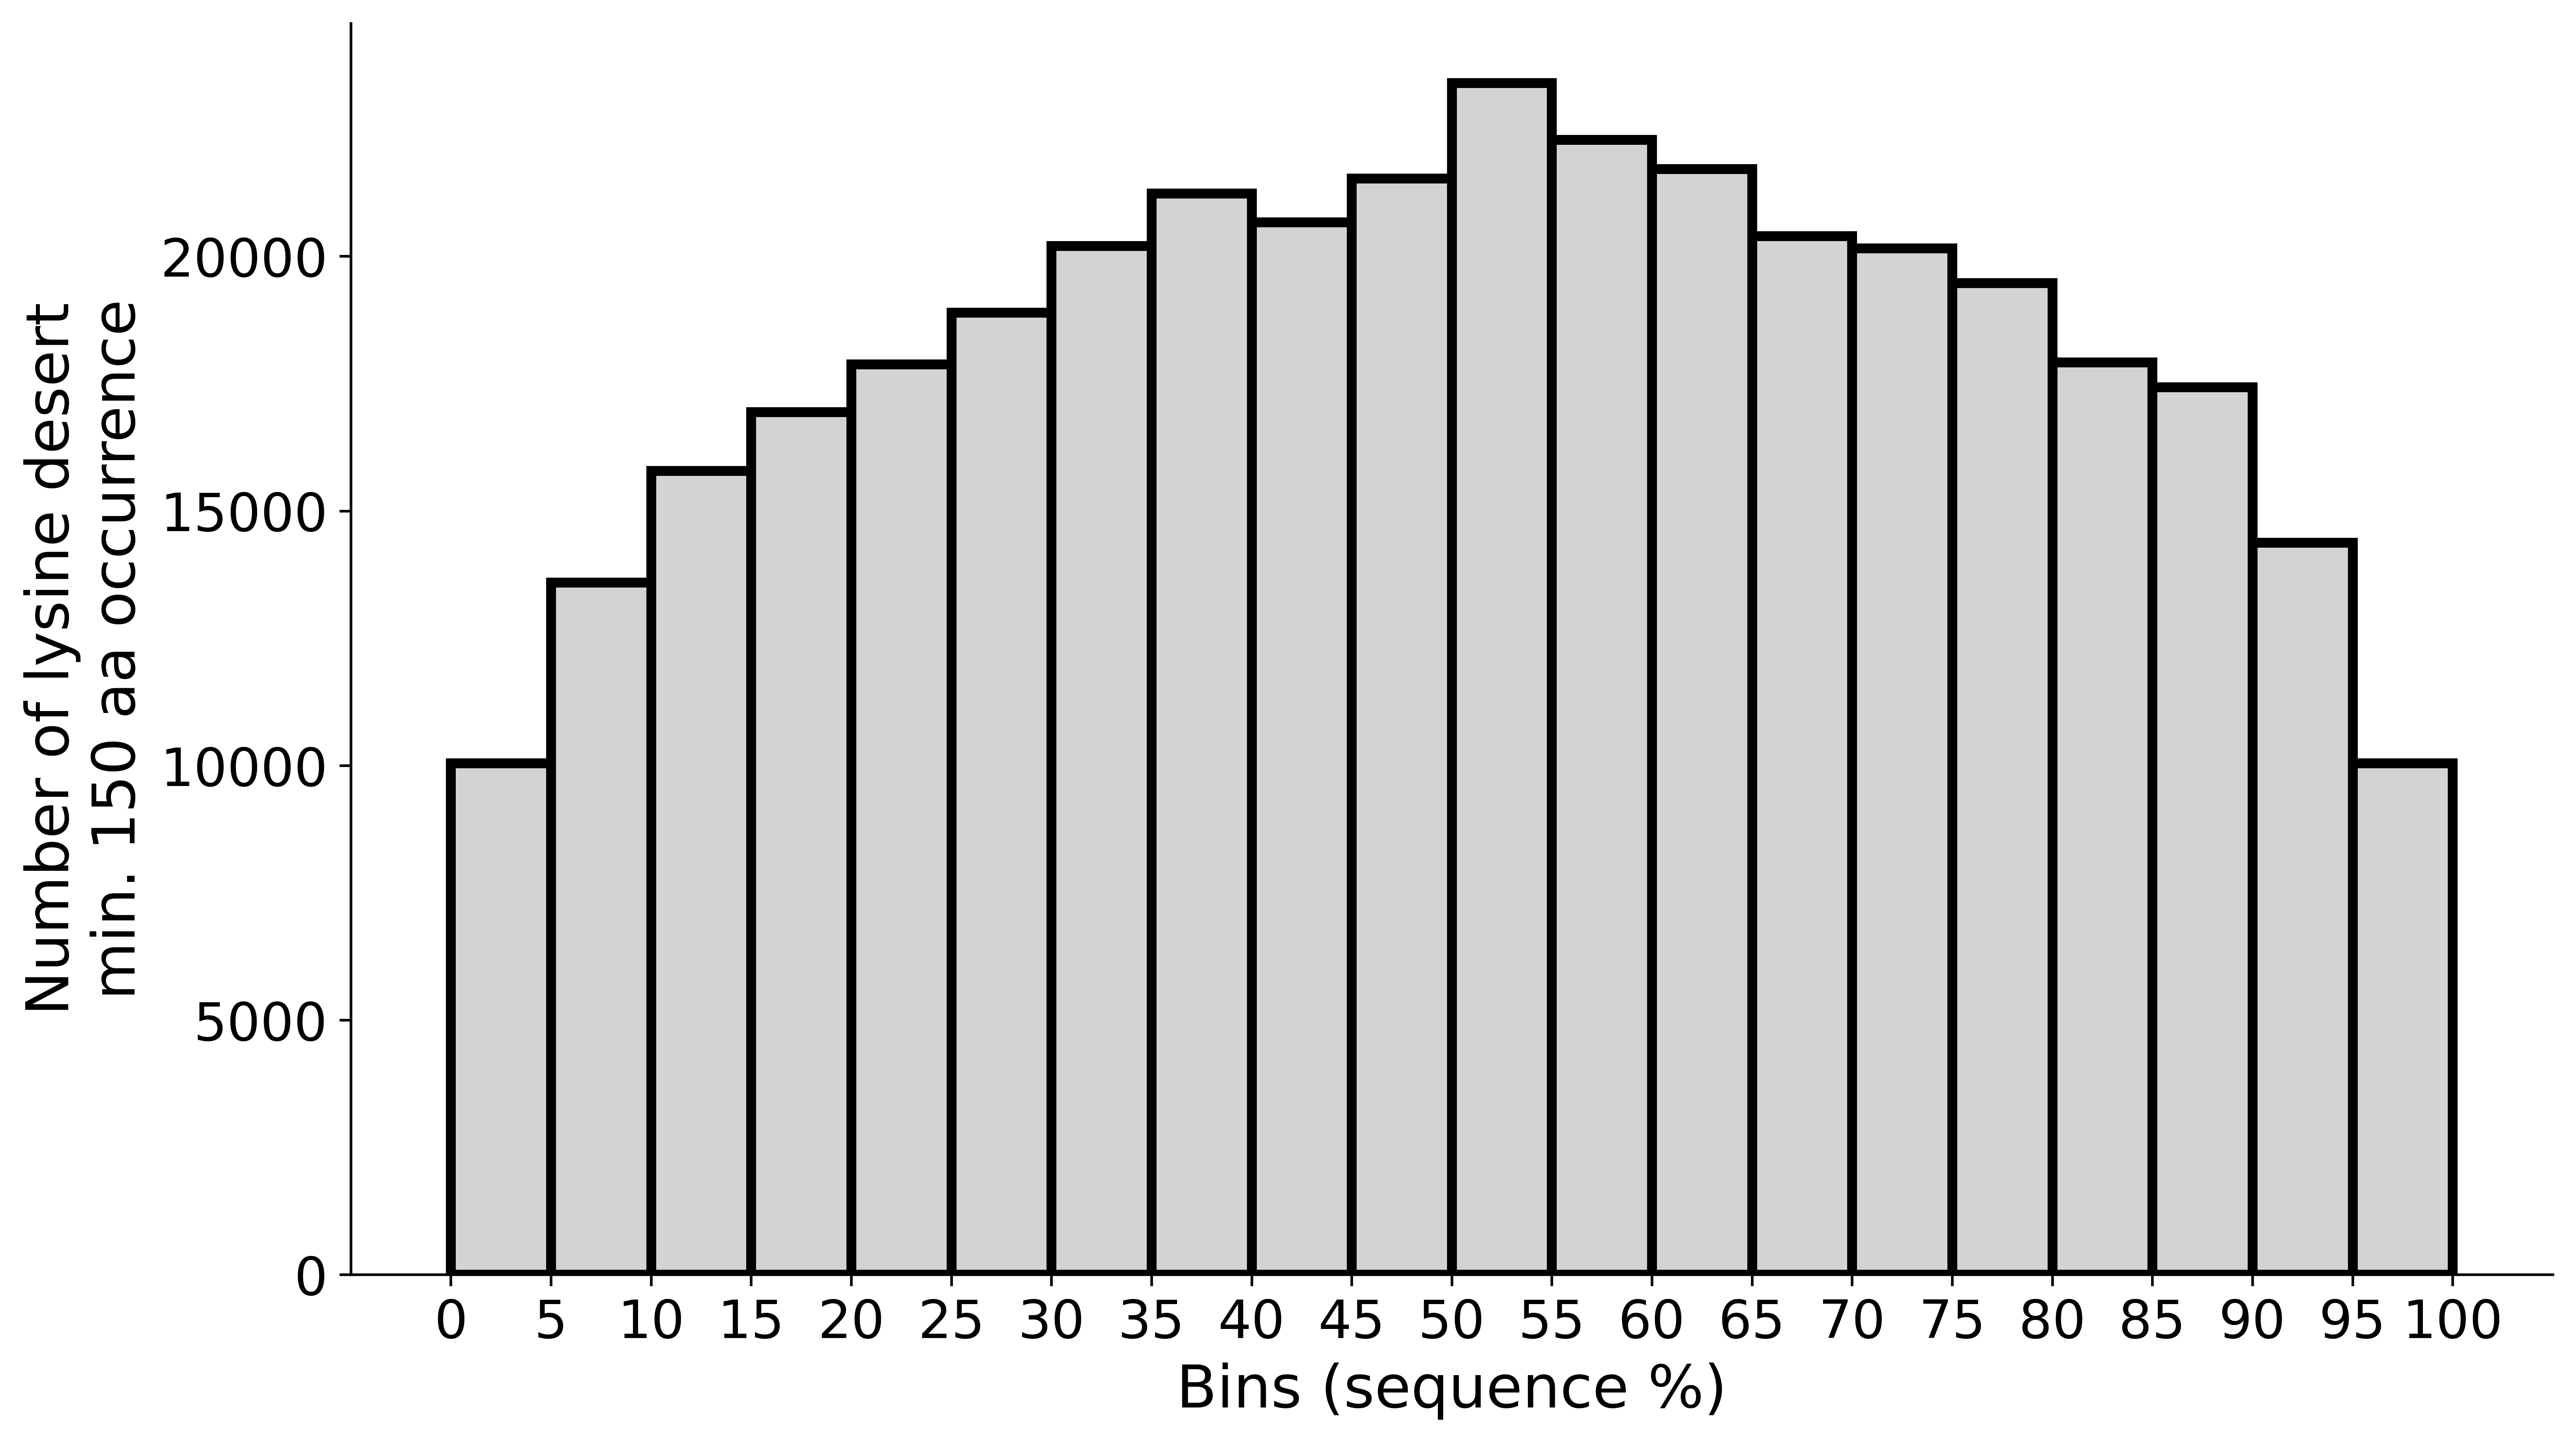

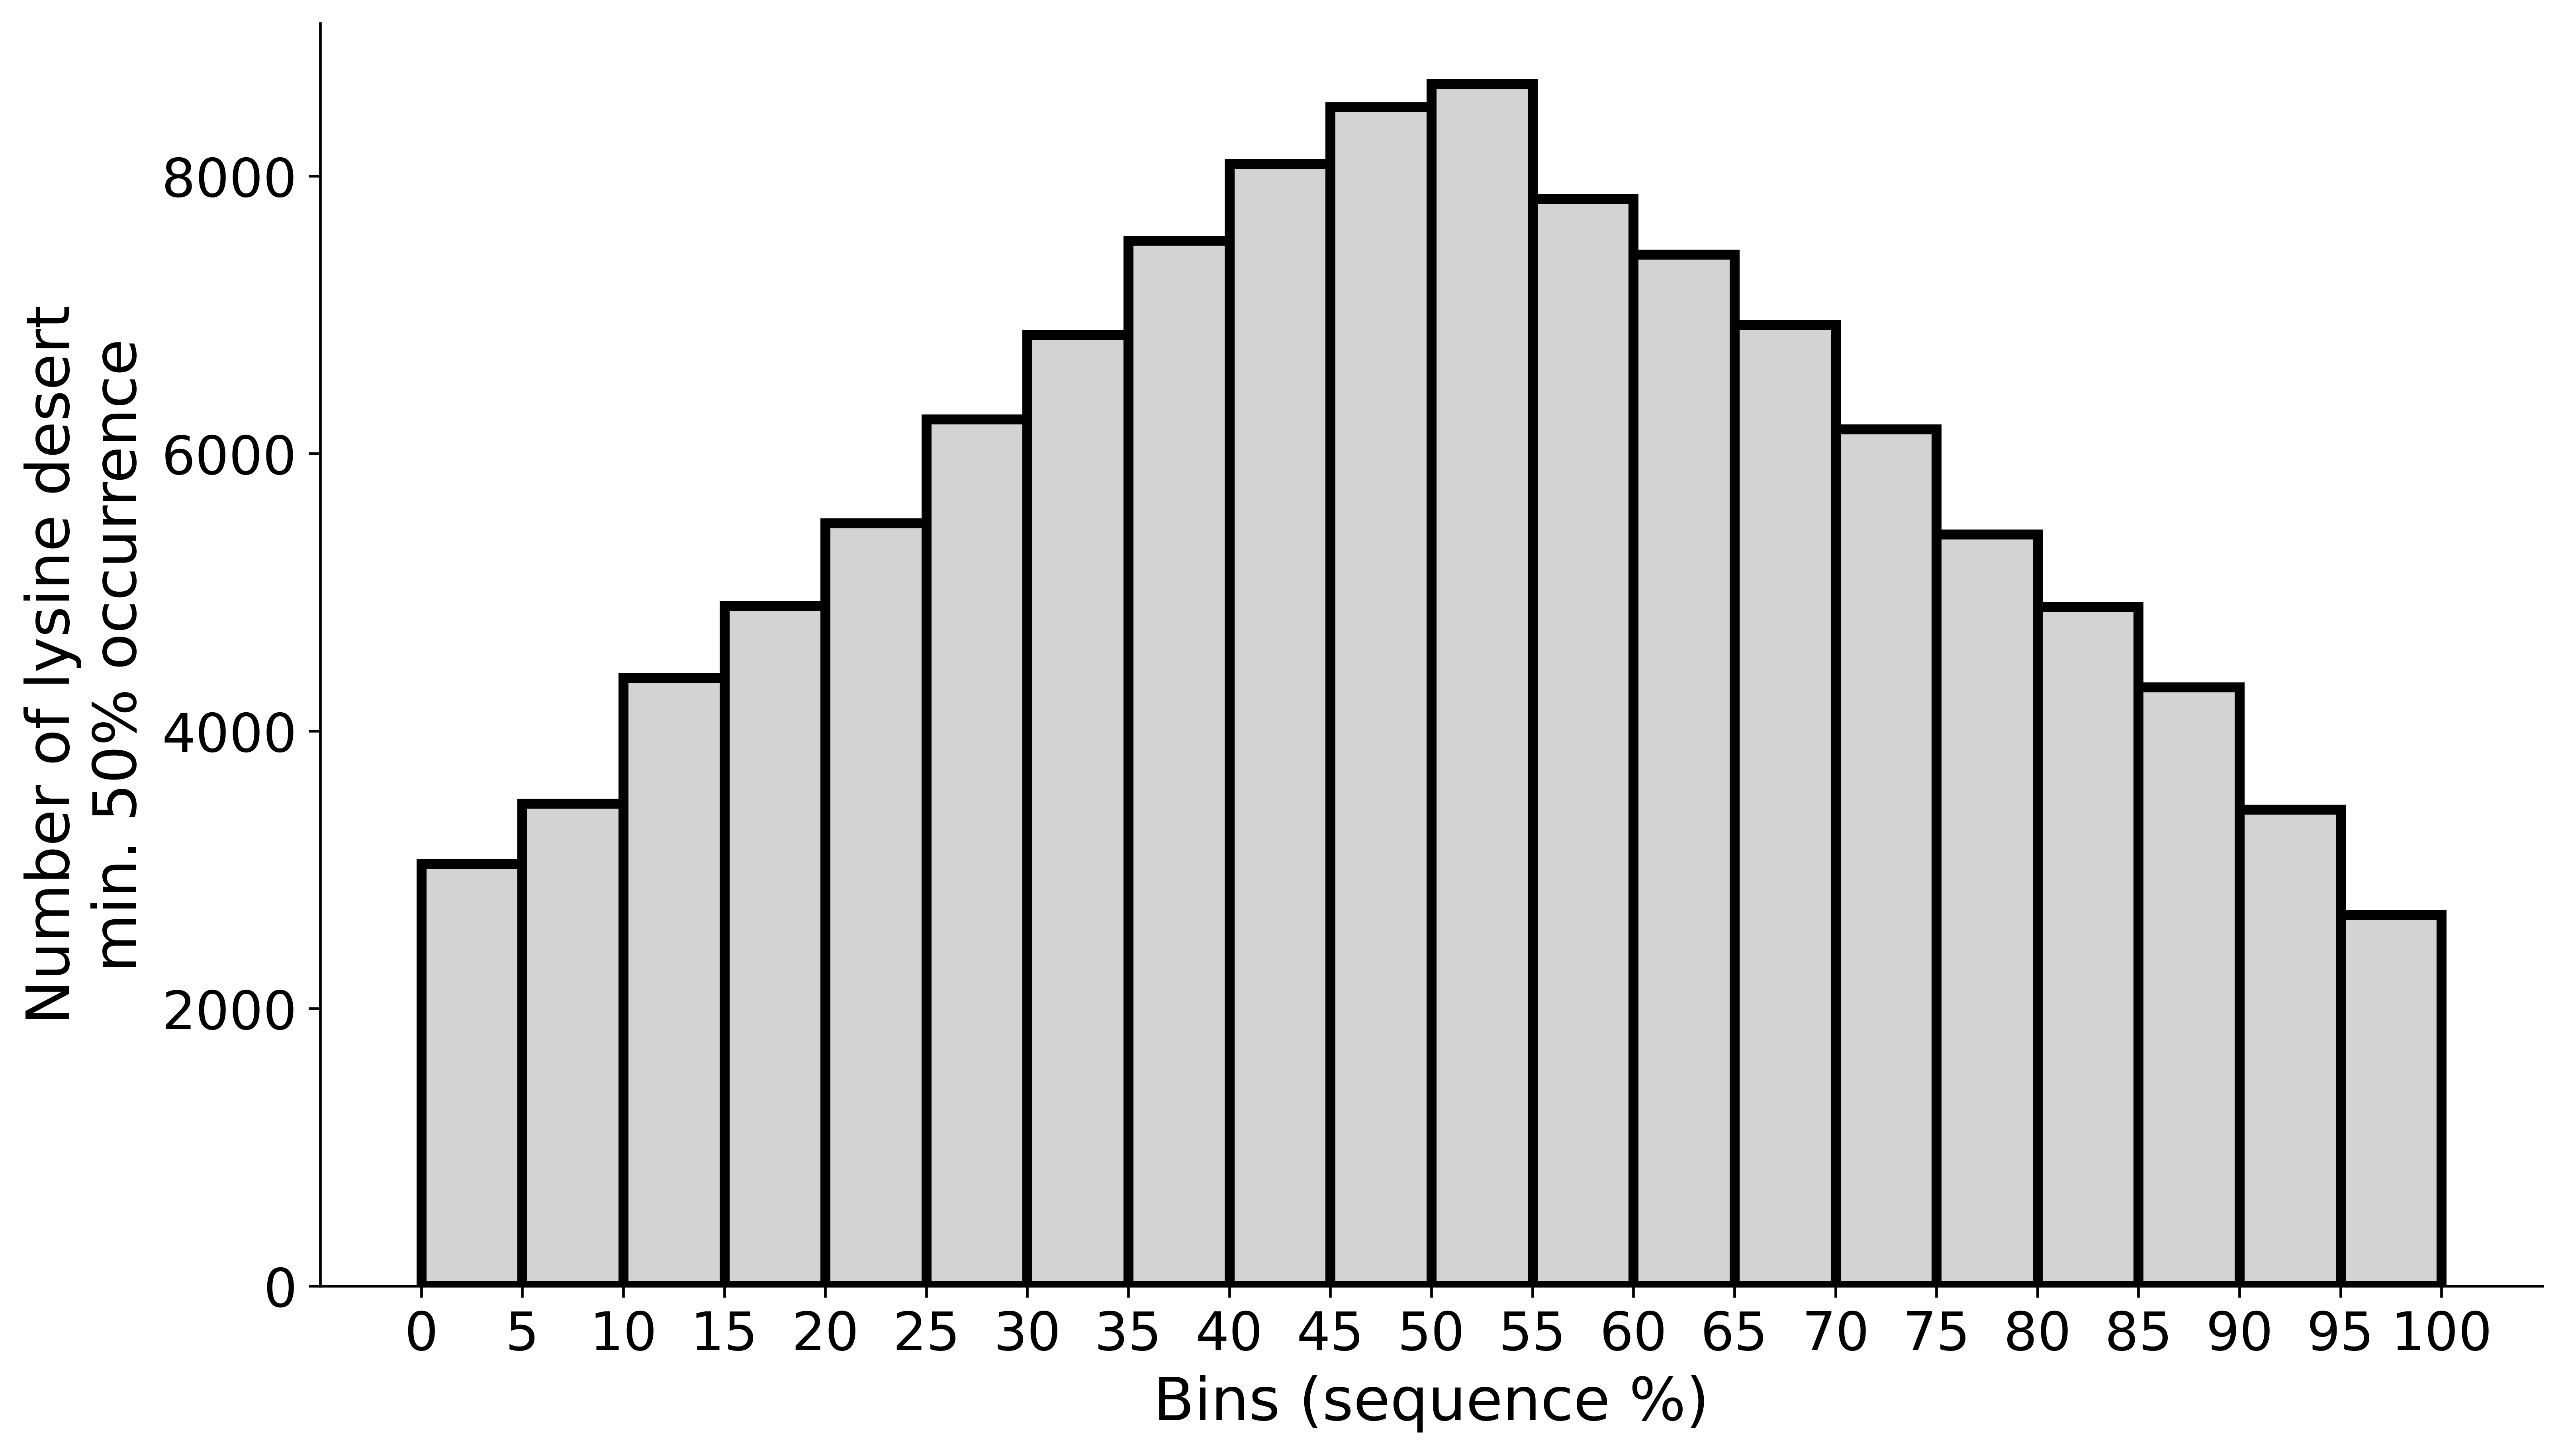

In [51]:
desert_dist('results/lysine_deserts_human_proteome.tsv.gz', 'Lysine desert 150', 'Lysine_desert_150_distribution.png')
desert_dist('results/lysine_deserts_human_proteome.tsv.gz', 'Lysine desert 0.5', 'Lysine_desert_0.5_distribution.png')

### 6.1.2. Lysines' distribution within proteins with a lysine desert

In [42]:
def lysine_dist(df_path, lys_des_cond, outname):
    
    data = [] 

    df_results = pd.read_csv(df_path, sep='\t')
    df_results = df_results[(df_results[lys_des_cond] == 'Yes') & (df_results["NumTMH"] <= TMH_max)]
    
    lengths = df_results['Sequence length'].tolist()
    seqs = df_results['Sequence'].tolist()
    
    fig, ax = plt.subplots(figsize = (12,7))
    
    for i in range(len(seqs)):
        all_K =  [x.start() for x in re.finditer('K',seqs[i])]
        for j in all_K:
            j_frac = int((j/lengths[i])*100)
            data.append(j_frac)
            
    if lys_des_cond == 'Lysine desert 150':
        desc = '150 aa'
    elif lys_des_cond == 'Lysine desert 0.5':
        desc = '50%'
    else:
        raise Exception('Unknown lys_des_cond')
        
    plt.hist(data, bins=range(0,105,5), color ='lightgrey',
             edgecolor ='black', linewidth=3)
    plt.xticks(range(0, 105, 5))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.xlabel('Bins (sequence %)', fontsize=18)
    plt.ylabel(f'Number of lysines within proteins\nwith lysine desert min. {desc}', fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()
    fig.savefig('results/distributions/lysine/' + outname, dpi=300, bbox_inches='tight')
    plt.close('all')

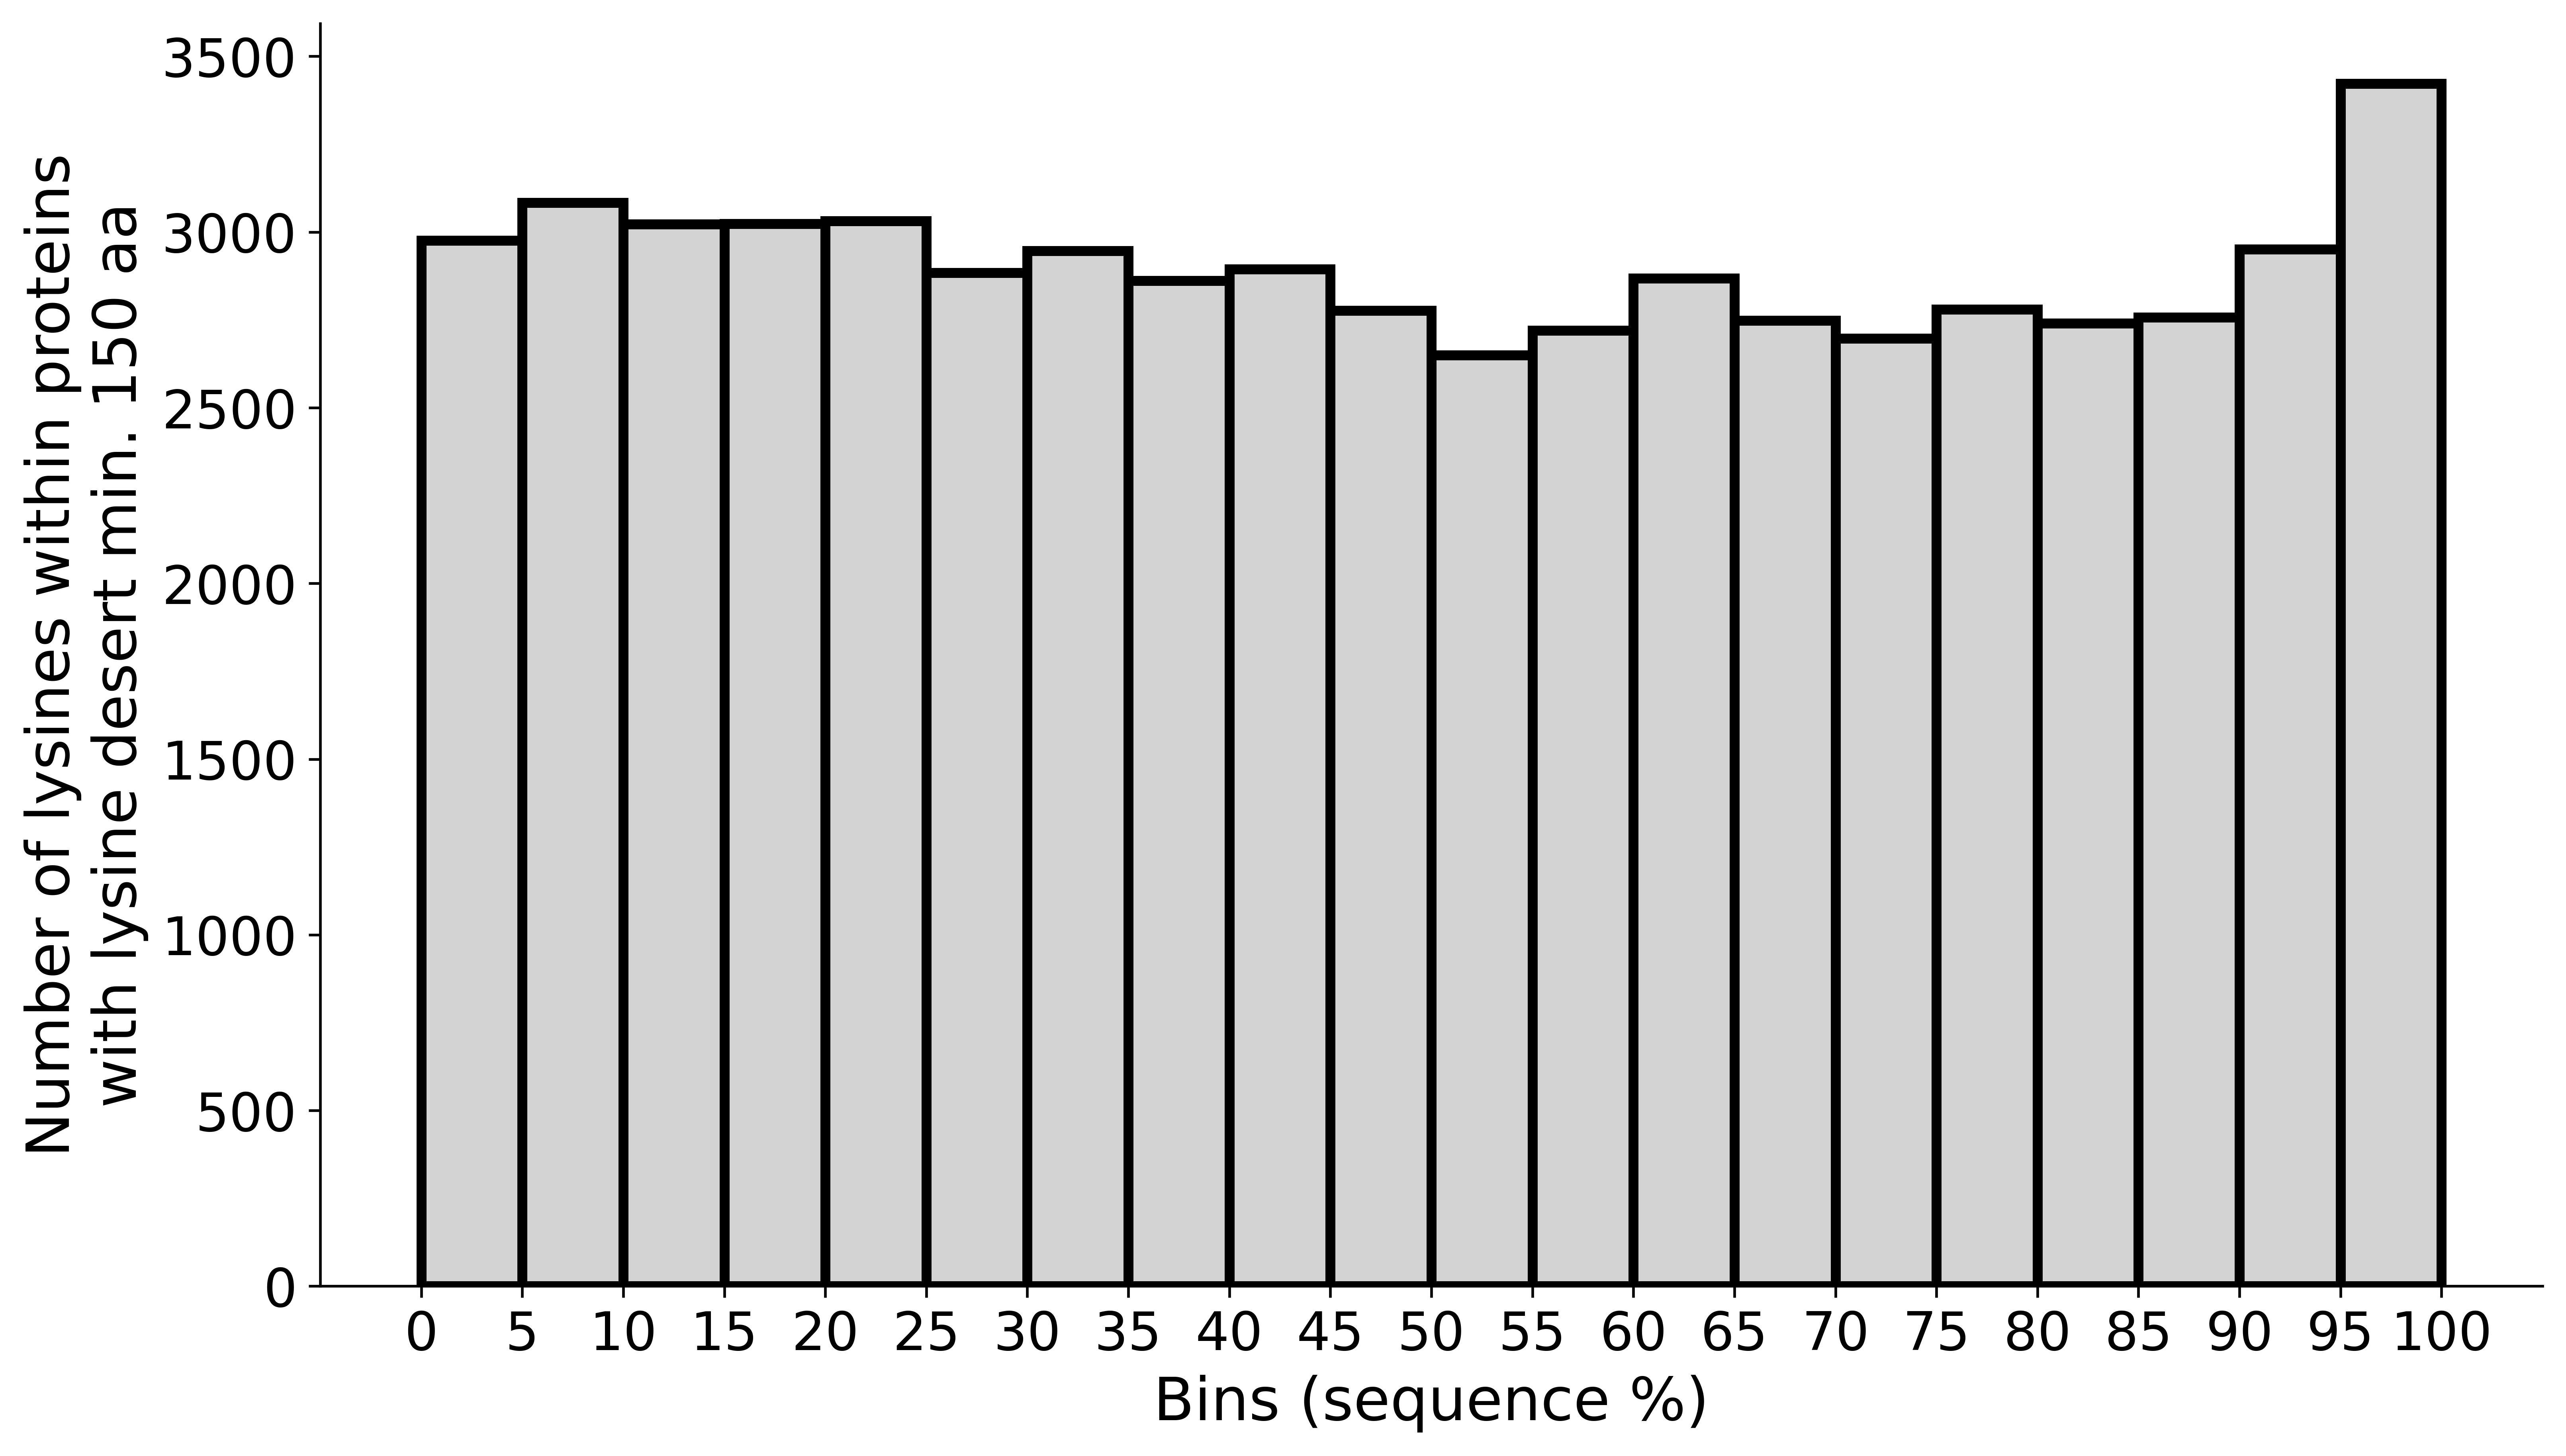

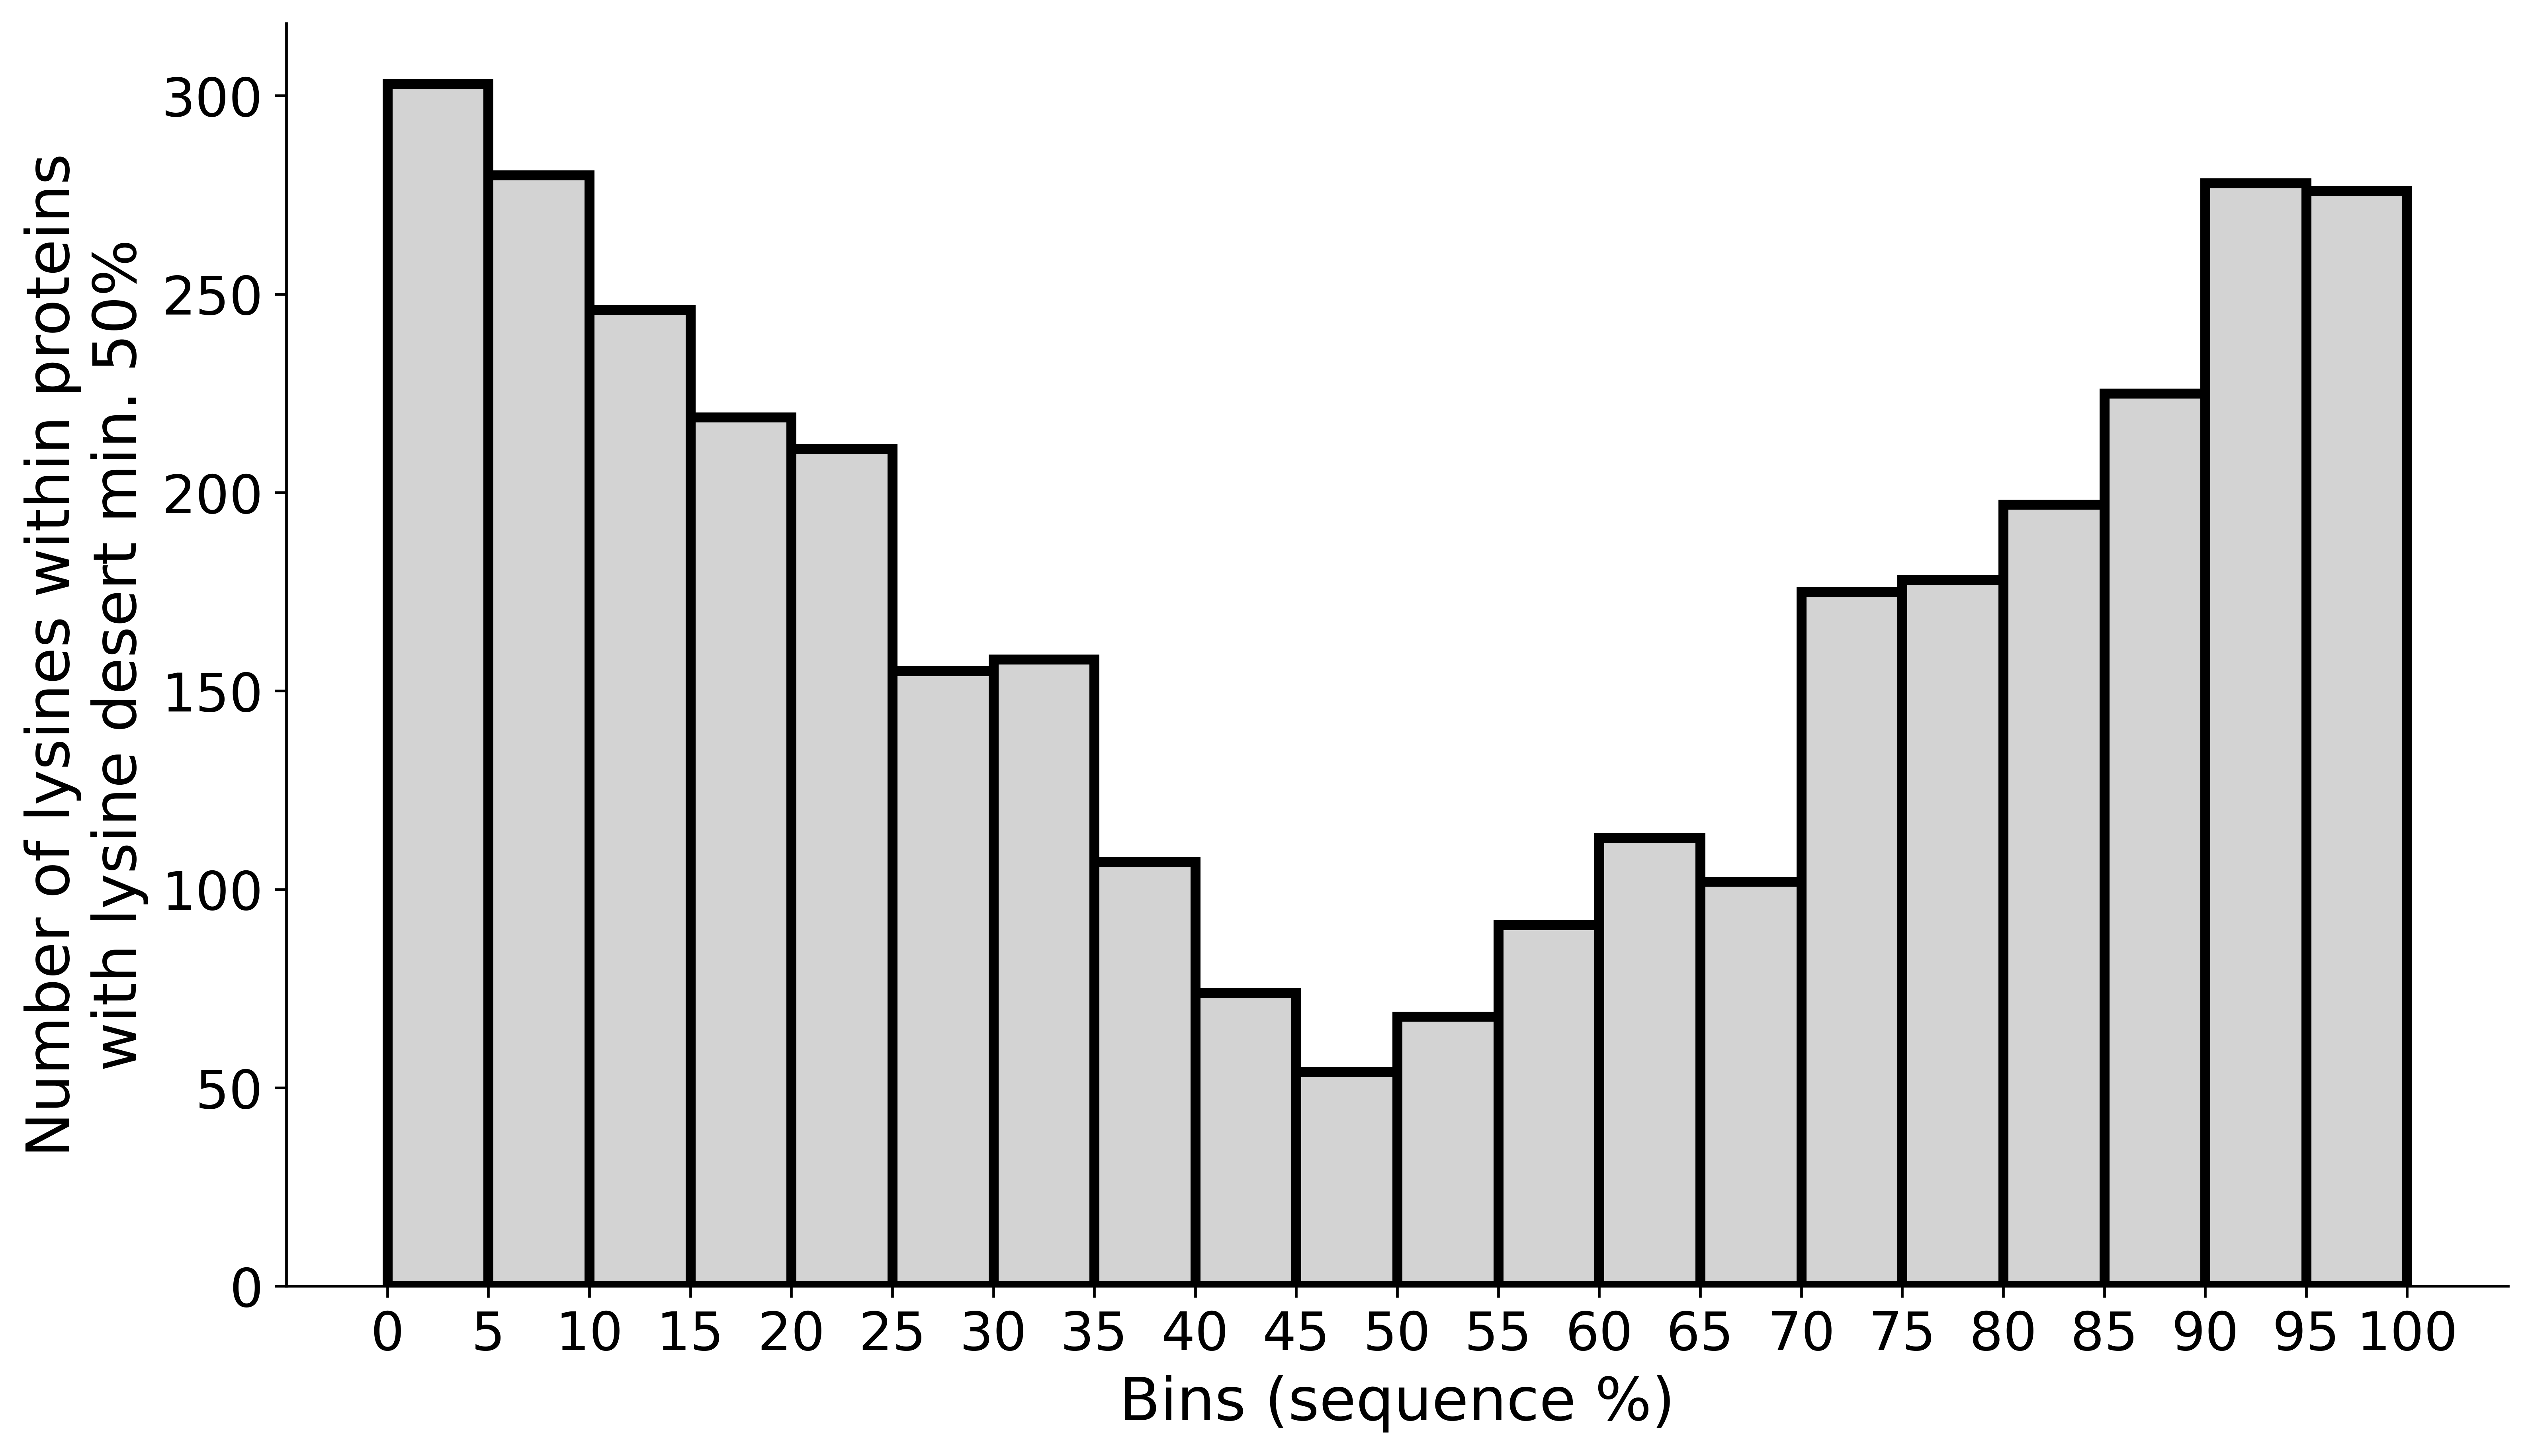

In [43]:
lysine_dist('results/lysine_deserts_human_proteome.tsv.gz', 'Lysine desert 150', 'Lysine_desert_150_distribution.png')
lysine_dist('results/lysine_deserts_human_proteome.tsv.gz', 'Lysine desert 0.5', 'Lysine_desert_0.5_distribution.png')

## 6.2. Calculate disorder scores among lysine deserts and lysine clusters

We will calculate disorder using two approaches: sequence-based IUPred3 and structure-based pLDDT (predicted Local Distance Difference Test)  values from the AlphaFold2 models.

## 6.2.1. IUPred3-based approach

Run IUPred3 on the reference UniProt human proteome UP000005640_9606, downloaded during analysis of proteomes of selected eukaryotic model organisms. Use the obtained predictions to check disorder of lysine deserts and lysine clusters among the lysine desert proteins.

### Prepare inputs - single line fasta files, separate for each sequence

Multiline fasta (one file) to singleline fasta (one file)

In [167]:
%%bash

mkdir -p data/human_proteome_single_seq
gzip -d ../Proteomes_analysis/data/Eukaryota_proteomes/UP000005640_9606.fasta.gz
awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < ../Proteomes_analysis/data/Eukaryota_proteomes/UP000005640_9606.fasta > data/human_proteome_single_seq/single.fa
gzip ../Proteomes_analysis/data/Eukaryota_proteomes/UP000005640_9606.fasta
awk 'NF' data/human_proteome_single_seq/single.fa > data/human_proteome_single_seq/single_clean.fa

Single line fasta to separate files

In [ ]:
f = open('data/human_proteome_single_seq/single_clean.fa', 'r')
lines = f.readlines()
f.close()

for l in lines:
    if l[0] == '>':
        name = l.split('|')[1]
        e = open(f'data/human_proteome_single_seq/{name}.fasta', 'w')
        e.write(f'>{name}\n')
        e.close()
    else:
        e = open(f'data/human_proteome_single_seq/{name}.fasta', 'a')
        e.write(f'{l}\n')
        e.close()

### Install standalone IUPred3 from [iupred3.elte.hu](https://iupred3.elte.hu/download_new)

### Run IUPred3 

####  Provide path to IUPred3 python script

Simply write it down in the field below 

e.g. `/Users/ns/Install/iupred3/iupred3.py`

**Do not hit ENTER after writing it down in the field below.**

In [159]:
db = HBox([Label('Full path to the IUPred3 software:'), Text()])
display(db)

In [161]:
iupred3_path = db.children[1].value # get path to the IUPred3 software path from Text object

#### Run IUPred3 

Run IUPred3 with deafult settings on all single line fasta files from `data/human_proteome_single_seq/`

In [ ]:
%%bash -s "$iupred3_path"

mkdir -p results/iupred_results
mkdir -p results/iupred_results/raw
cd data/human_proteome_single_seq/

for f in `ls *.fasta`; do name=`echo $f | cut -d'.' -f1`; python3 $1 $f long > ../../results/iupred_results/raw/${name}_iupred.out ; done

### Parse IUPred3 results

Create a dictionary with UniProtIDs as keys and IUPred3 scores for all protein residues

In [169]:
f = open('data/human_proteome_single_seq/single_clean.fa', 'r')
lines = f.readlines()
f.close()
all_uniprots_over_min_length = []

for l in lines:
    if l[0] == '>':
        nazwa = l.split('|')[1]
        all_uniprots_over_min_length.append(nazwa)
    else:
        if len(l) < seq_min_length:
            del all_uniprots_over_min_length[-1]
            
iupred_dict = {}

for el in all_uniprots_over_min_length:
    f = open(f'results/iupred_results/raw/{el}_iupred.out')
    lines = f.readlines()
    f.close()
    iupred_dict[el] = []
    for l in lines:
        if l[0] != '#':
            iupred_val = float(l.split('\t')[2].strip())
            iupred_dict[el].append(iupred_val)
            
with open('results/iupred_dict.pickle', 'wb') as handle:
    pickle.dump(iupred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Check lysine deserts' disorder

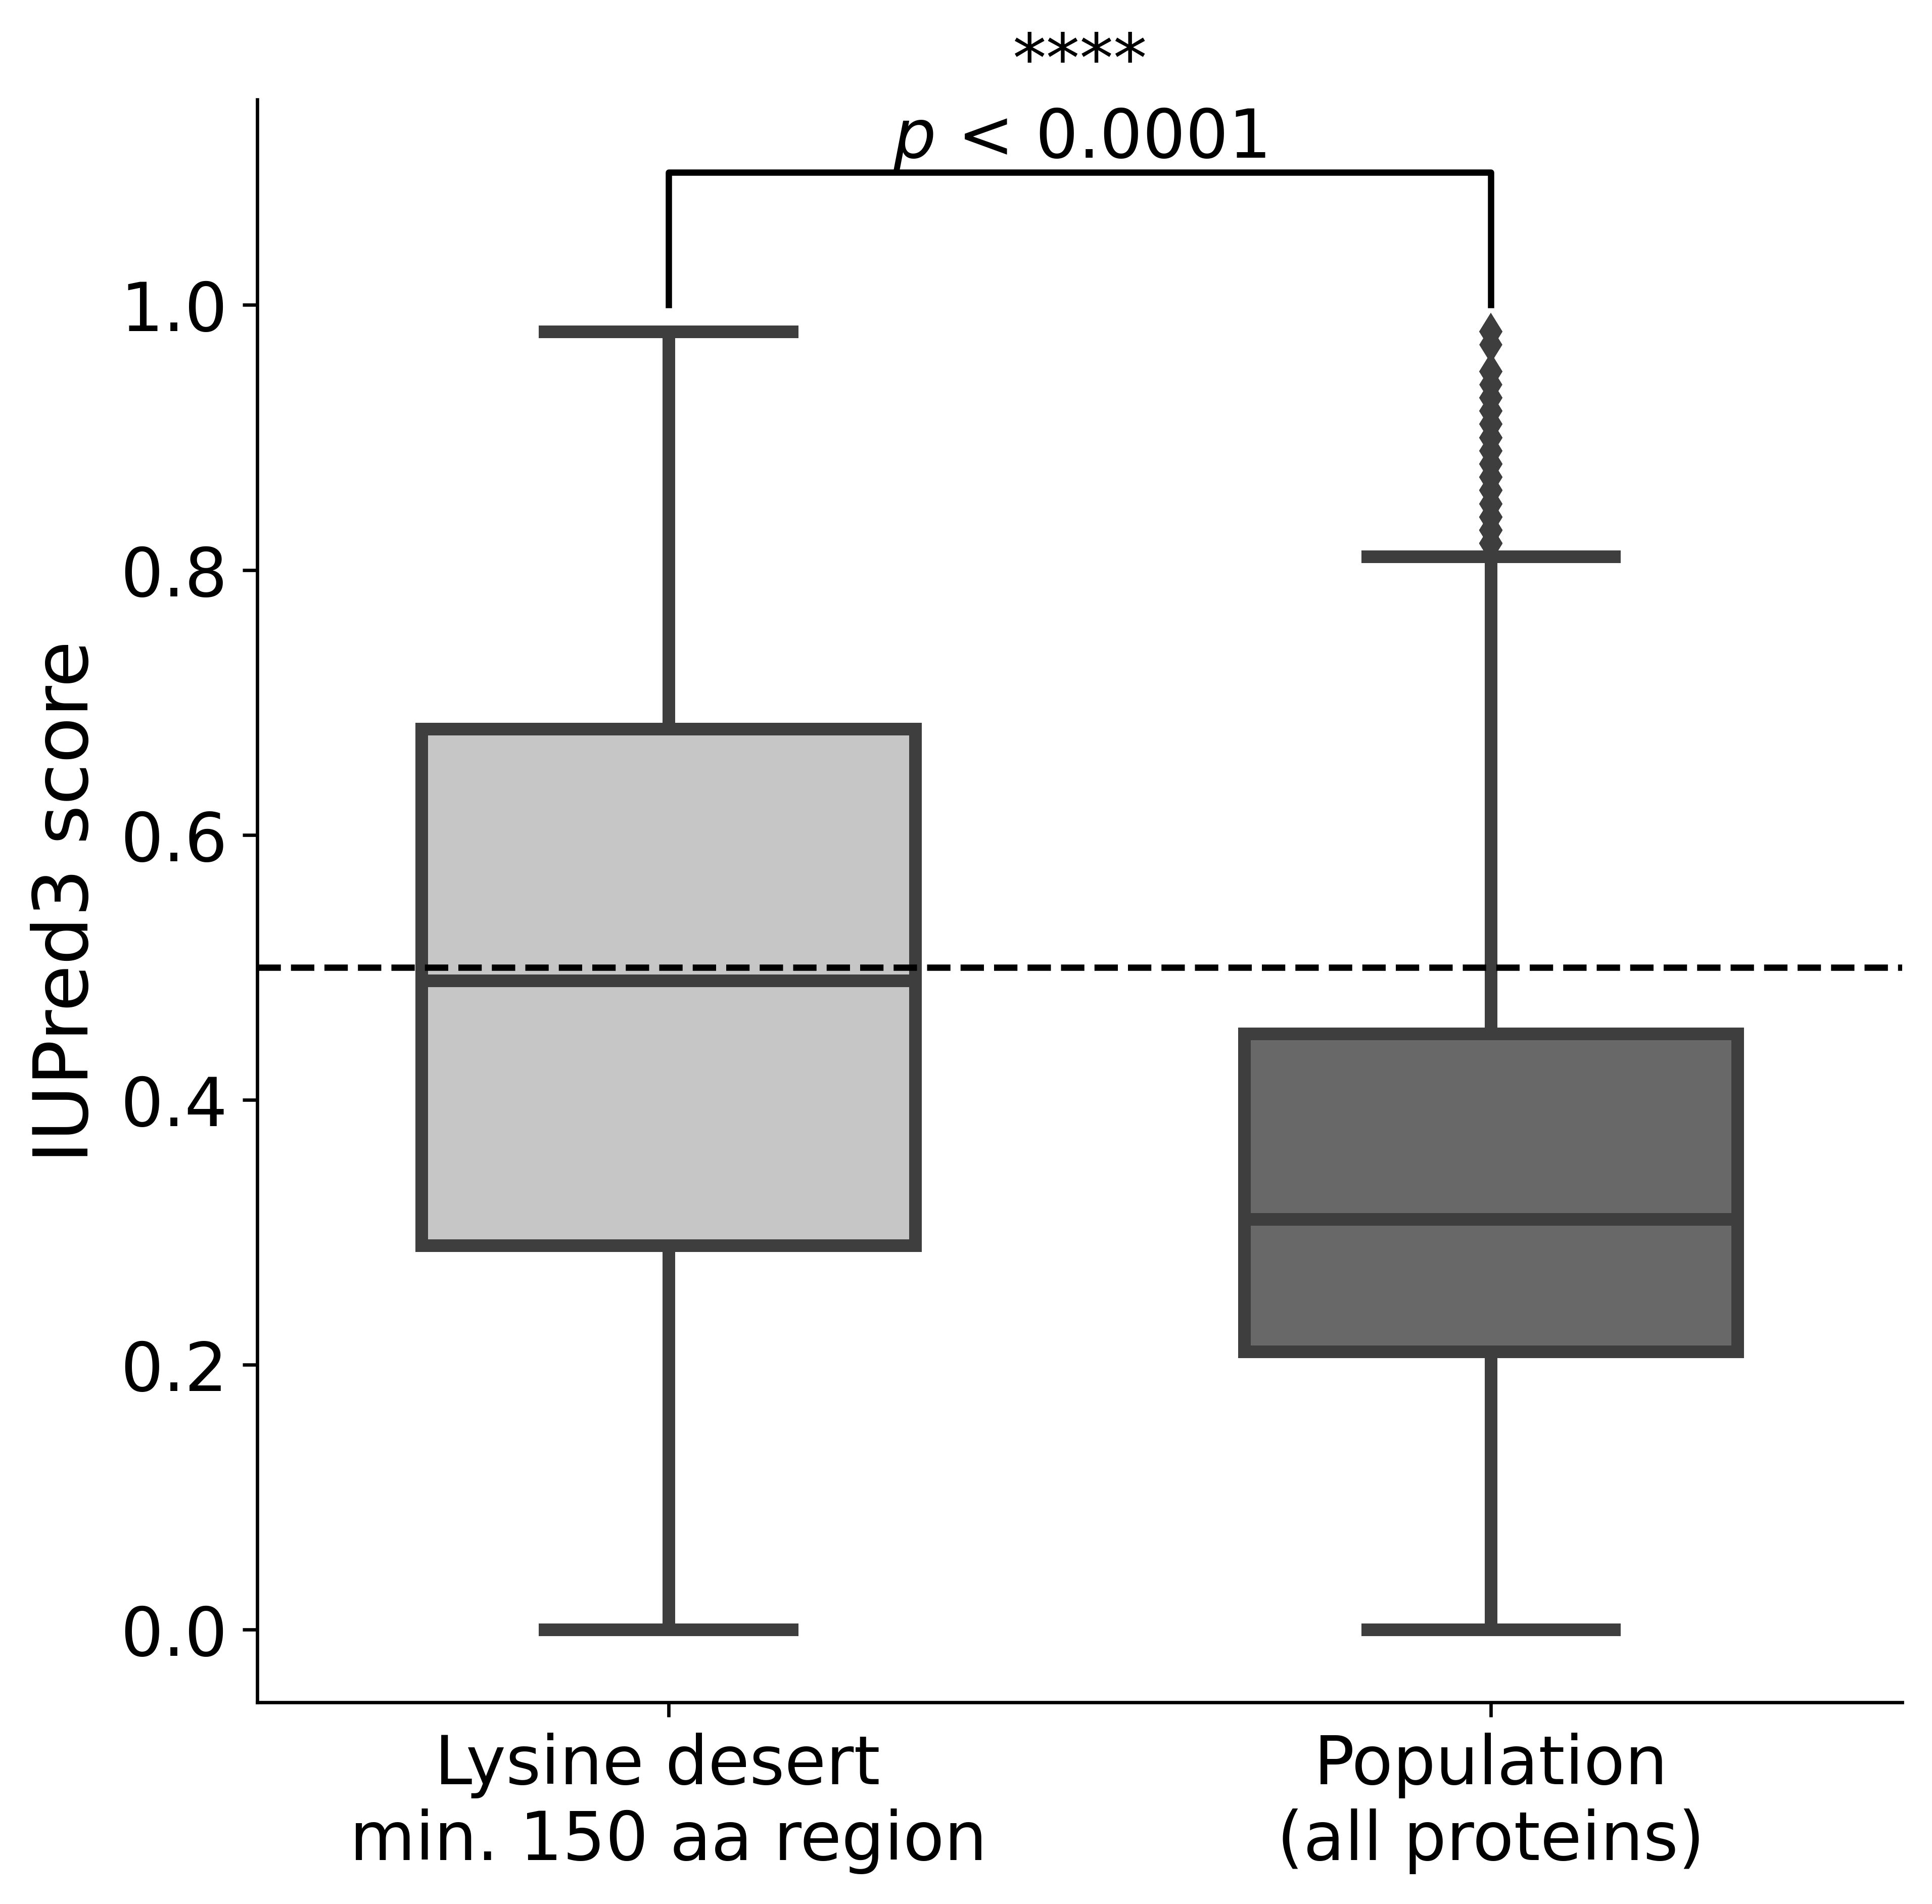

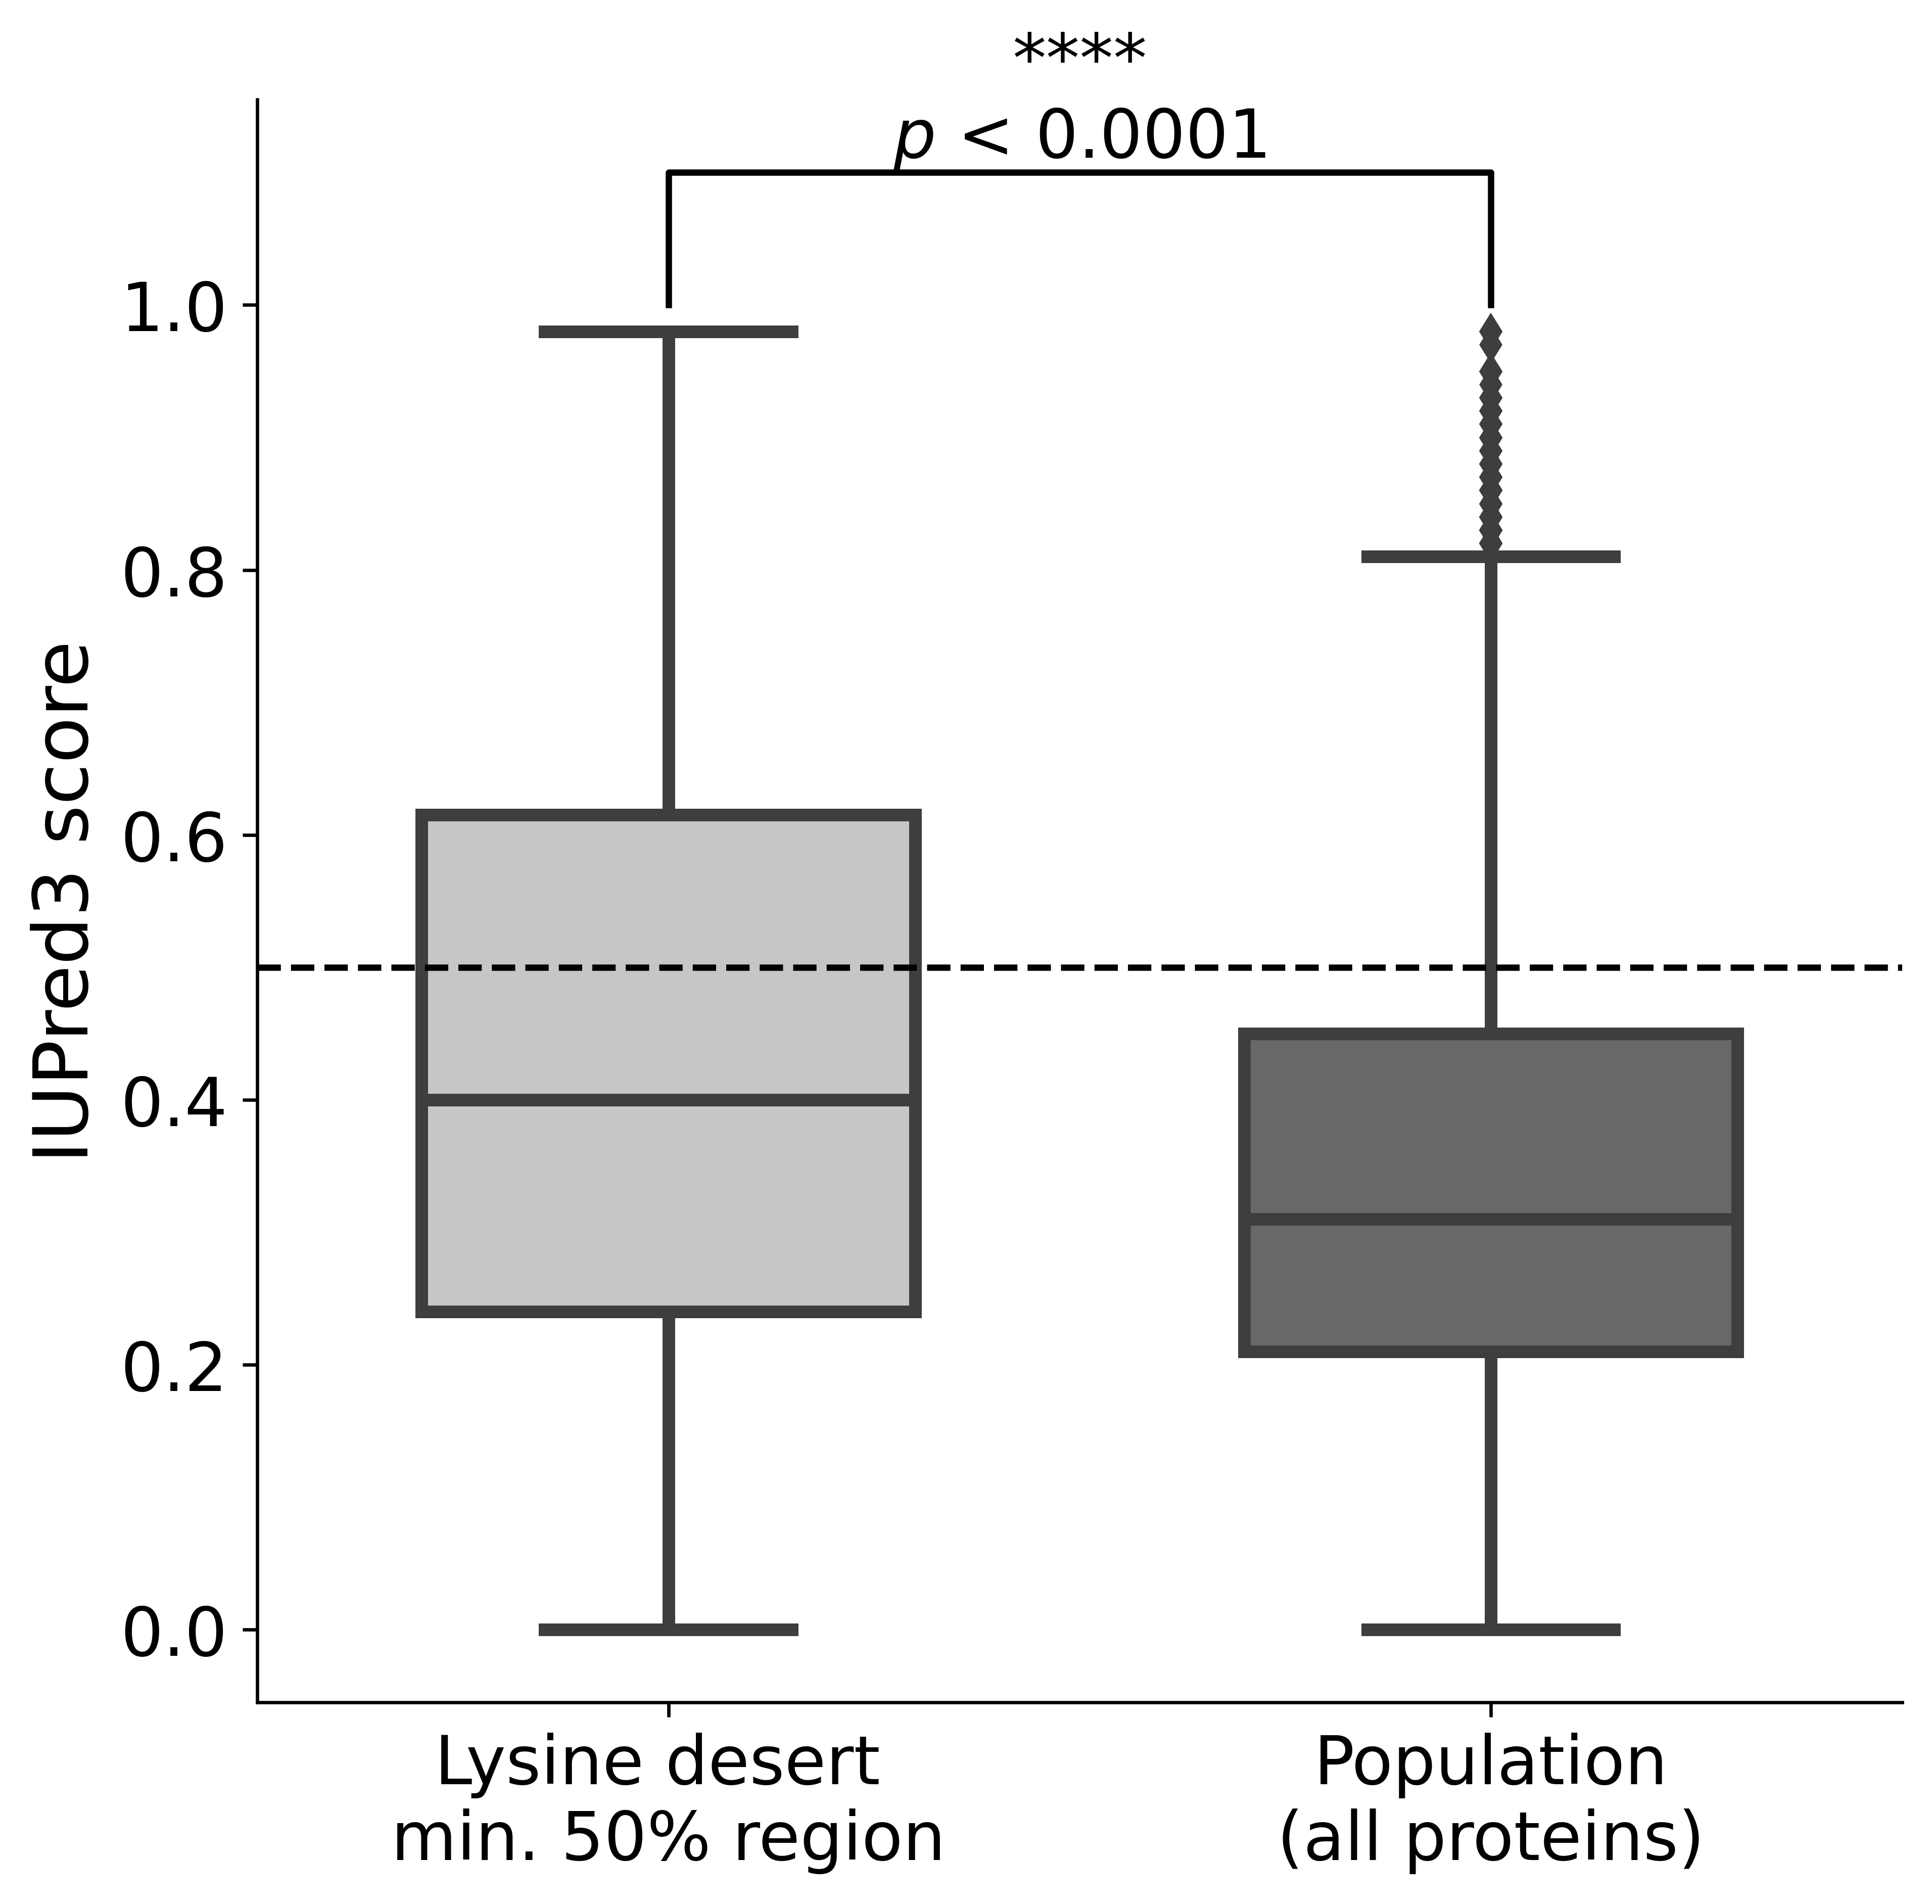

In [113]:
with open('results/iupred_dict.pickle', 'rb') as handle:
    iupred_dict = pickle.load(handle)
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_results = df_results[(df_results["NumTMH"] <= TMH_max) & (df_results["Sequence length"] >=seq_min_length)]

# If only for RING-type E3s
#df_results = df_results[df_results['E3 class'] == 'RING']

for des_length in desert_min_lengths:
    mean_disorder_desert = []
    mean_disorder_population = []
    
    for ident, value in df_results.iterrows():

        uniprot = value[0]
        seq = value[4]
        start = int(value[29])
        end = int(value[30])
        
        if des_length == 150:
            desert = value[21]
            desc_desert = '150 aa'
        elif des_length == 0.5:
            desert = value[22]
            desc_desert = '50%'
        else:
            raise Exception('Unknown desert length')

        if uniprot not in iupred_dict.keys(): continue
        if len(iupred_dict[uniprot]) != len(seq): continue

        if desert == "Yes":
            mean_disorder_desert.append(round(statistics.mean(iupred_dict[uniprot][start:end]),2))

        mean_disorder_population.append(round(statistics.mean(iupred_dict[uniprot]),2))
        
    ### Plot results ###
    plt.rcParams['figure.figsize']=(7,7)
    ax = sns.boxplot(data=[mean_disorder_desert, mean_disorder_population],  width=.6, palette='Greys', linewidth=3)
    
    plt.xticks(plt.xticks()[0], [f'Lysine desert \nmin. {desc_desert} region', 'Population\n(all proteins)'],fontsize=16);
    # If only for RING-type E3s
    #plt.xticks(plt.xticks()[0], [f'Lysine desert \nmin. {desc_desert} region', 'Population\n(all RING E3s)'],fontsize=16);
    
    ax.set_ylabel("IUPred3 score",fontsize=18);
    ax.tick_params(labelsize=16)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.axhline(0.5, c='black', ls='--')
    U1, pvalue = mannwhitneyu(mean_disorder_desert, mean_disorder_population)
    pval_round = round(pvalue,4)
    if pvalue > 0.05:
        symbol = 'ns'
        p_text = "$\it{p}$ = " +str(pval_round)
    elif pvalue <= 0.05 and pvalue > 0.01:
        symbol = '*'
        p_text = "$\it{p}$ = " +str(pval_round)
    elif pvalue <= 0.01 and pvalue > 0.001:
        symbol = '**'
        p_text = "$\it{p}$ = " +str(pval_round)
    elif pvalue <= 0.001 and pvalue > 0.0001:
        symbol = '***'
        p_text = "$\it{p}$ = " +str(pval_round)
    else:
        symbol = '****'
        p_text = "$\it{p}$ < 0.0001"

    # statistical annotation
    x1, x2 = 0, 1   
    y, h, col = 1.0 , 0.1, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, f"{symbol}\n{p_text}", ha='center', va='bottom', color=col, size=16);
    plt.savefig(f'results/desert_disorder/IUPRED_desert{des_length}.png', dpi=600, bbox_inches='tight')
    # If only for RING-type E3s
    #plt.savefig(f'results/desert_disorder/IUPRED_desert_E3_RING_only_{des_length}.png', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close('all')


### Check lysine clusters' disorder within lysine desert proteins

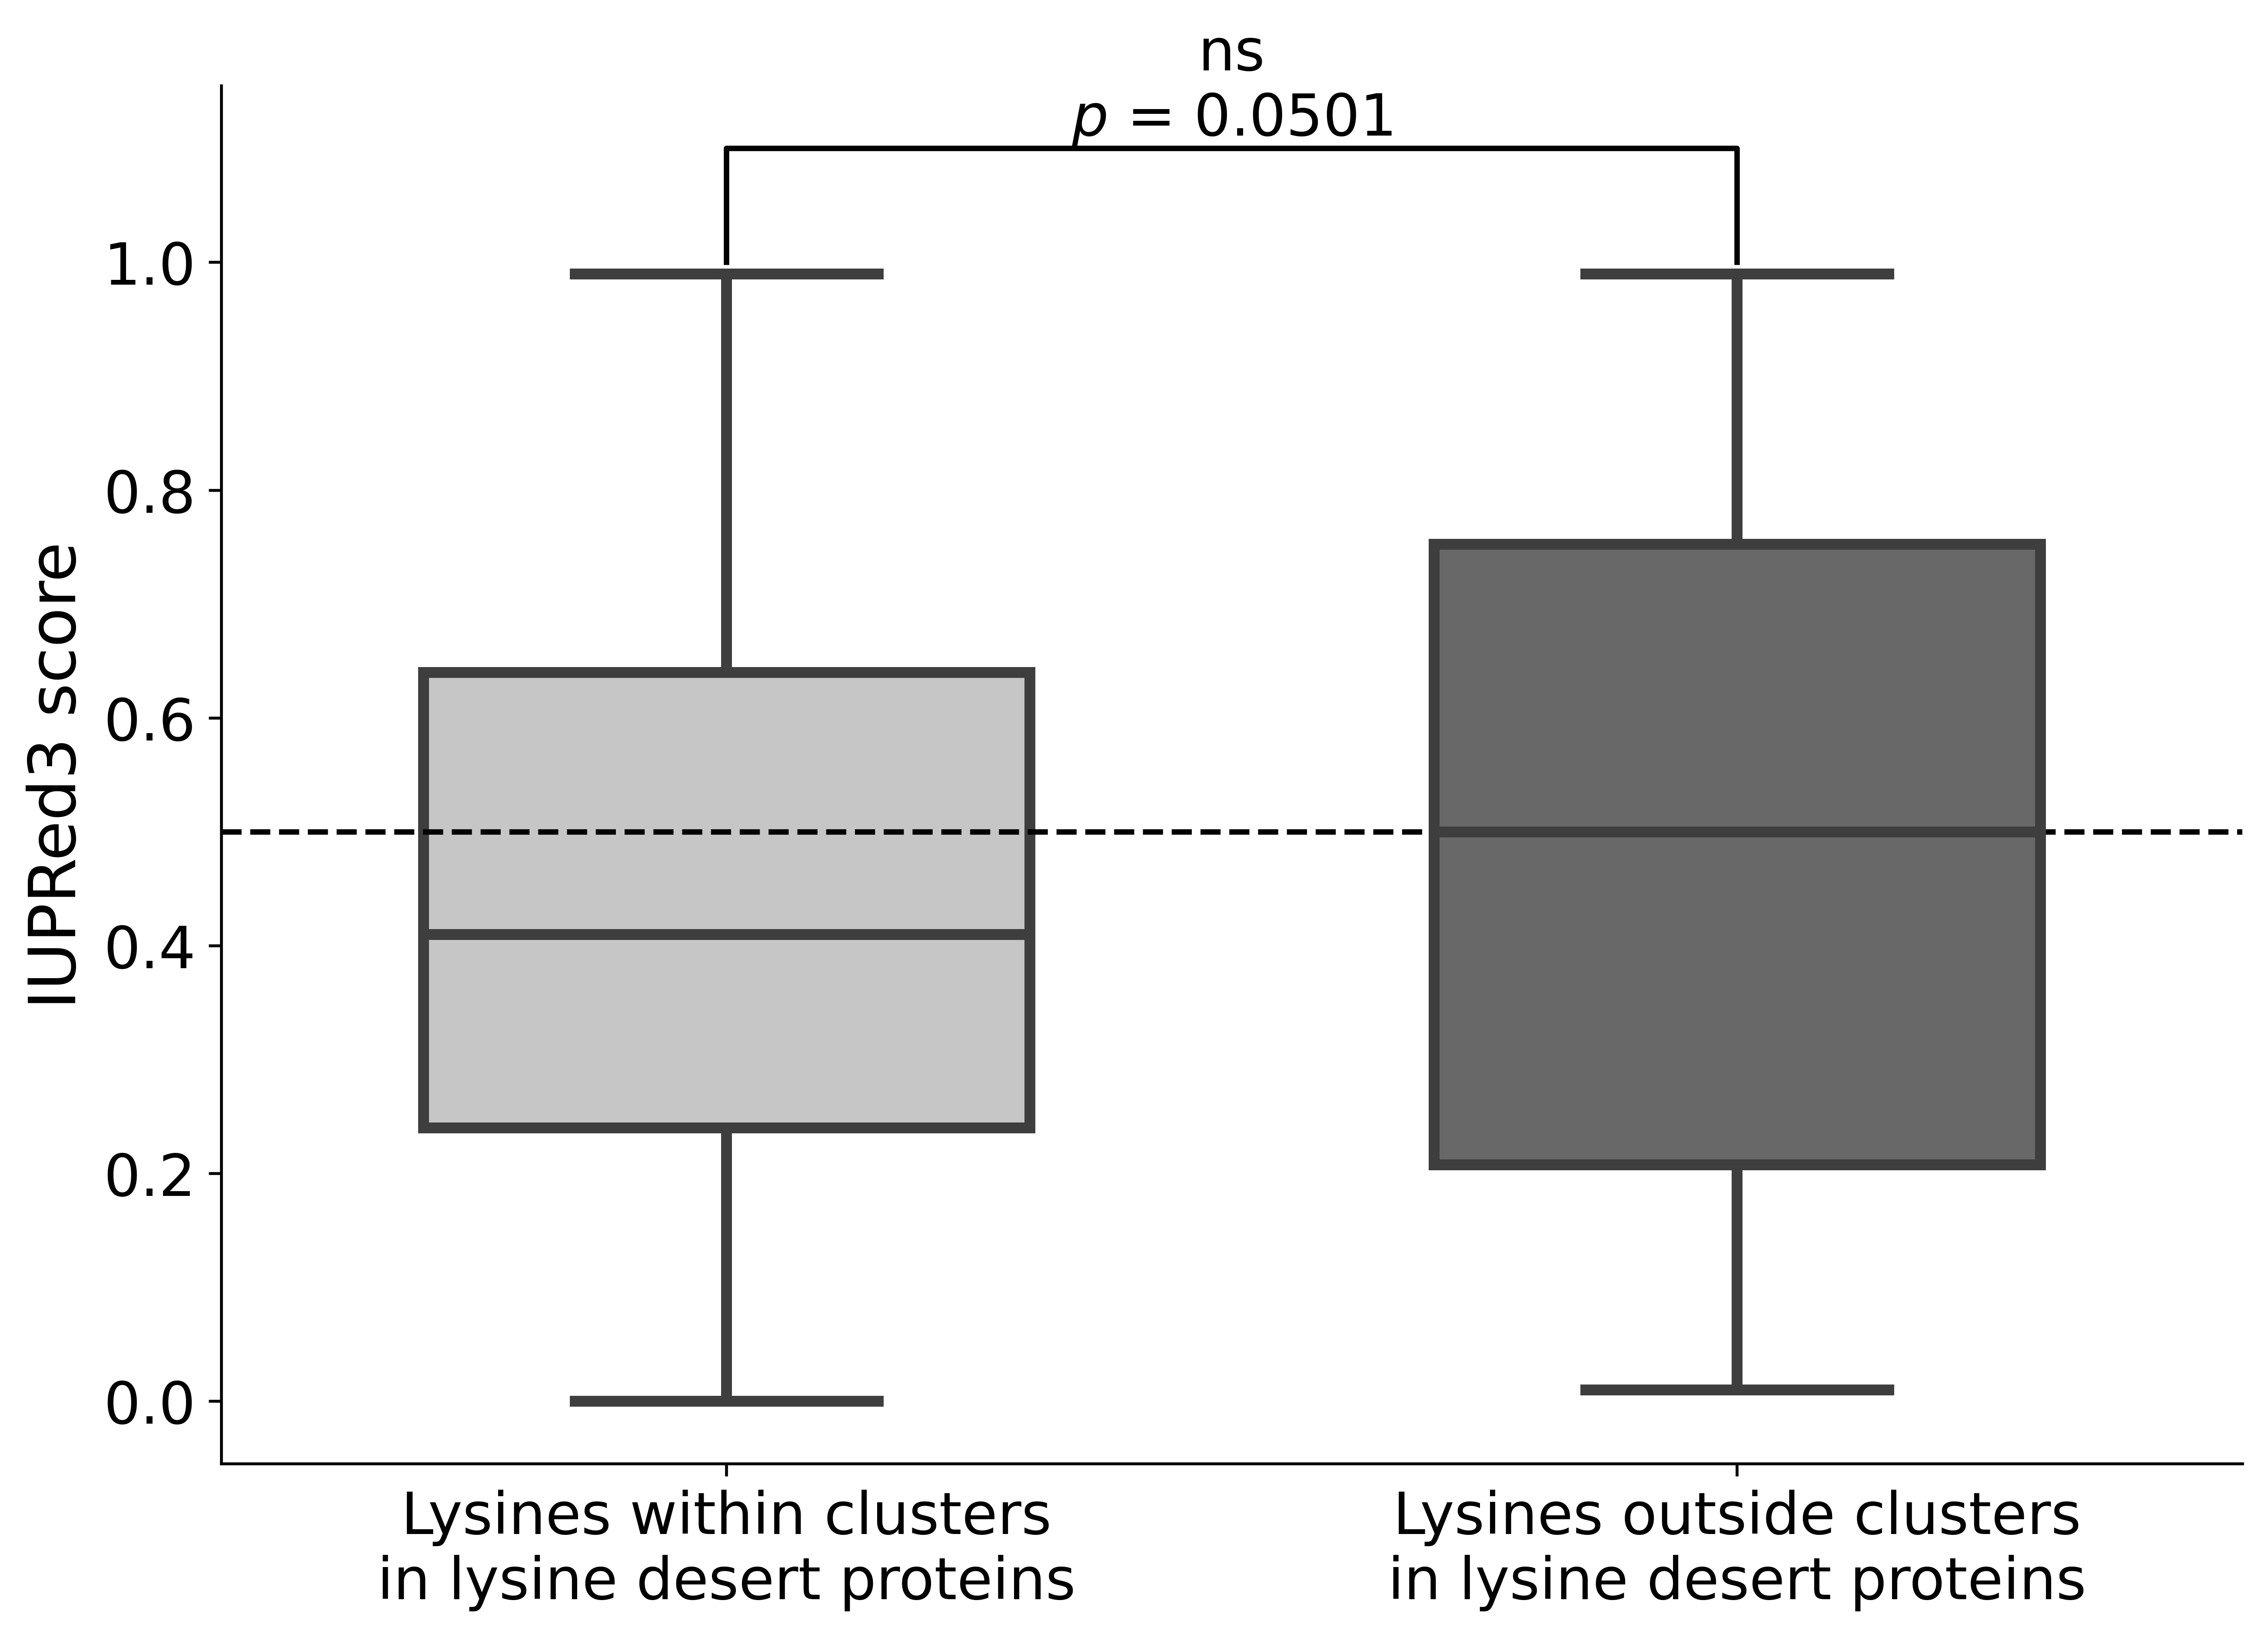

In [107]:
with open('results/iupred_dict.pickle', 'rb') as handle:
    iupred_dict = pickle.load(handle)
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_results = df_results[(df_results["NumTMH"] <= TMH_max) & (df_results["Sequence length"] >=seq_min_length)]

mean_disorder_lyscluster = []
mean_disorder_population_withindesert = []
already_with_desert_uniprots = set()

for des_length in desert_min_lengths:
    for ident, value in df_results.iterrows():

        uniprot = value[0]
        seq = value[4]
        start = int(value[29])
        end = int(value[30])
        cluster_anywhere = value[23]
        left_idx_smallest = value[26]
        right_idx_largest = value[27]
        
        if des_length == 150:
            desert = value[21]
            desc_desert = '150 aa'
        elif des_length == 0.5:
            desert = value[22]
            desc_desert = '50%'
        else:
            raise Exception('Unknown desert length')

        if uniprot not in iupred_dict.keys(): continue
        if len(iupred_dict[uniprot]) != len(seq): continue

        if desert == "Yes" and cluster_anywhere == 'Yes' and uniprot not in already_with_desert_uniprots:
            already_with_desert_uniprots.add(uniprot)
            all_lys_cluster = []
            all_lys_outside_desert_population = []

            for i in range(len(seq)):
                if seq[i] == 'K':
                    if i in range(int(left_idx_smallest), int(right_idx_largest)+1):
                        all_lys_cluster.append(i)
                    else:
                        all_lys_outside_desert_population.append(i)

            for el in all_lys_outside_desert_population:
                mean_disorder_population_withindesert.append(round((iupred_dict[uniprot][el]),2))
            for el in all_lys_cluster:
                mean_disorder_lyscluster.append(round((iupred_dict[uniprot][el]),2))

        else:
            continue
            
### Plot results ###
plt.rcParams['figure.figsize']=(10,7)
ax = sns.boxplot(data=[mean_disorder_lyscluster, mean_disorder_population_withindesert],   width=.6, palette='Greys', linewidth=3)
plt.xticks(plt.xticks()[0], [f'Lysines within clusters\nin lysine desert proteins', 'Lysines outside clusters\nin lysine desert proteins'],fontsize=16);

ax.set_ylabel("IUPRed3 score",fontsize=18);
ax.tick_params(labelsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axhline(0.5, c='black', ls='--')

U1, pvalue = mannwhitneyu(mean_disorder_lyscluster, mean_disorder_population_withindesert)
pval_round = round(pvalue,4)

if pvalue > 0.05:
    symbol = 'ns'
    p_text = "$\it{p}$ = " +str(pval_round)
elif pvalue <= 0.05 and pvalue > 0.01:
    symbol = '*'
    p_text = "$\it{p}$ = " +str(pval_round)
elif pvalue <= 0.01 and pvalue > 0.001:
    symbol = '**'
    p_text = "$\it{p}$ = " +str(pval_round)
elif pvalue <= 0.001 and pvalue > 0.0001:
    symbol = '***'
    p_text = "$\it{p}$ = " +str(pval_round)
else:
    symbol = '****'
    p_text = "$\it{p}$ < 0.0001"

# statistical annotation
x1, x2 = 0, 1   
y, h, col = 1.0 , 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, f"{symbol}\n{p_text}", ha='center', va='bottom', color=col, size=16);
plt.savefig(f'results/lyscluster_disorder/lysine_clusters_among_deserta_IUPRED3.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close('all')

## 6.2.2. pLDDT-based approach

Obtain pLDDT values indicating residues' disorder from the AlphaFold2 models of the human proteome (the same as used in the structural lysine desert search). Use the obtained values to check disorder of lysine deserts and lysine clusters among the lysine desert proteins.

In [5]:
%%bash -s

mkdir -p results/plddt_results

In [ ]:
with open('data/human_proteome_single_seq/single_clean.fa') as f:
    lines = [line.rstrip() for line in f]
all_uniprots_appropriate_length = []

for l in lines:
    if l[0] == '>':
        nazwa = l.split('|')[1]
        all_uniprots_appropriate_length.append(nazwa)
    else:
        if len(l) < seq_min_length or len(l) > 2700: # we do not consider too short or proteins split by the AlphaFold2 to separate files (> 2700 aa)
            del all_uniprots_appropriate_length[-1]

plldt_dict = {}
for el in all_uniprots_appropriate_length:
    plldt_dict[el] = []

    try:
        structure = parser.get_structure("afold", f'../Structral_lysine_deserts_search/data/Afold_structures/H_sapiens/AF-{el}-F1-model_v3.pdb')
    except:
        continue
    model = structure[0]

    for chain in model:
        for residue in chain:
            pLDDT = None

            for atom in residue:
                if pLDDT is None:
                    pLDDT = atom.get_bfactor()
                if pLDDT != atom.get_bfactor():
                    raise Exception(f'{el} residue {residue} has different pLDDT scores')

            plldt_dict[el].append(pLDDT)

with open('results/plddt_results/plddt_dict.pickle', 'wb') as handle:
    pickle.dump(plldt_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Check lysine deserts' disorder based on the pLLDT values

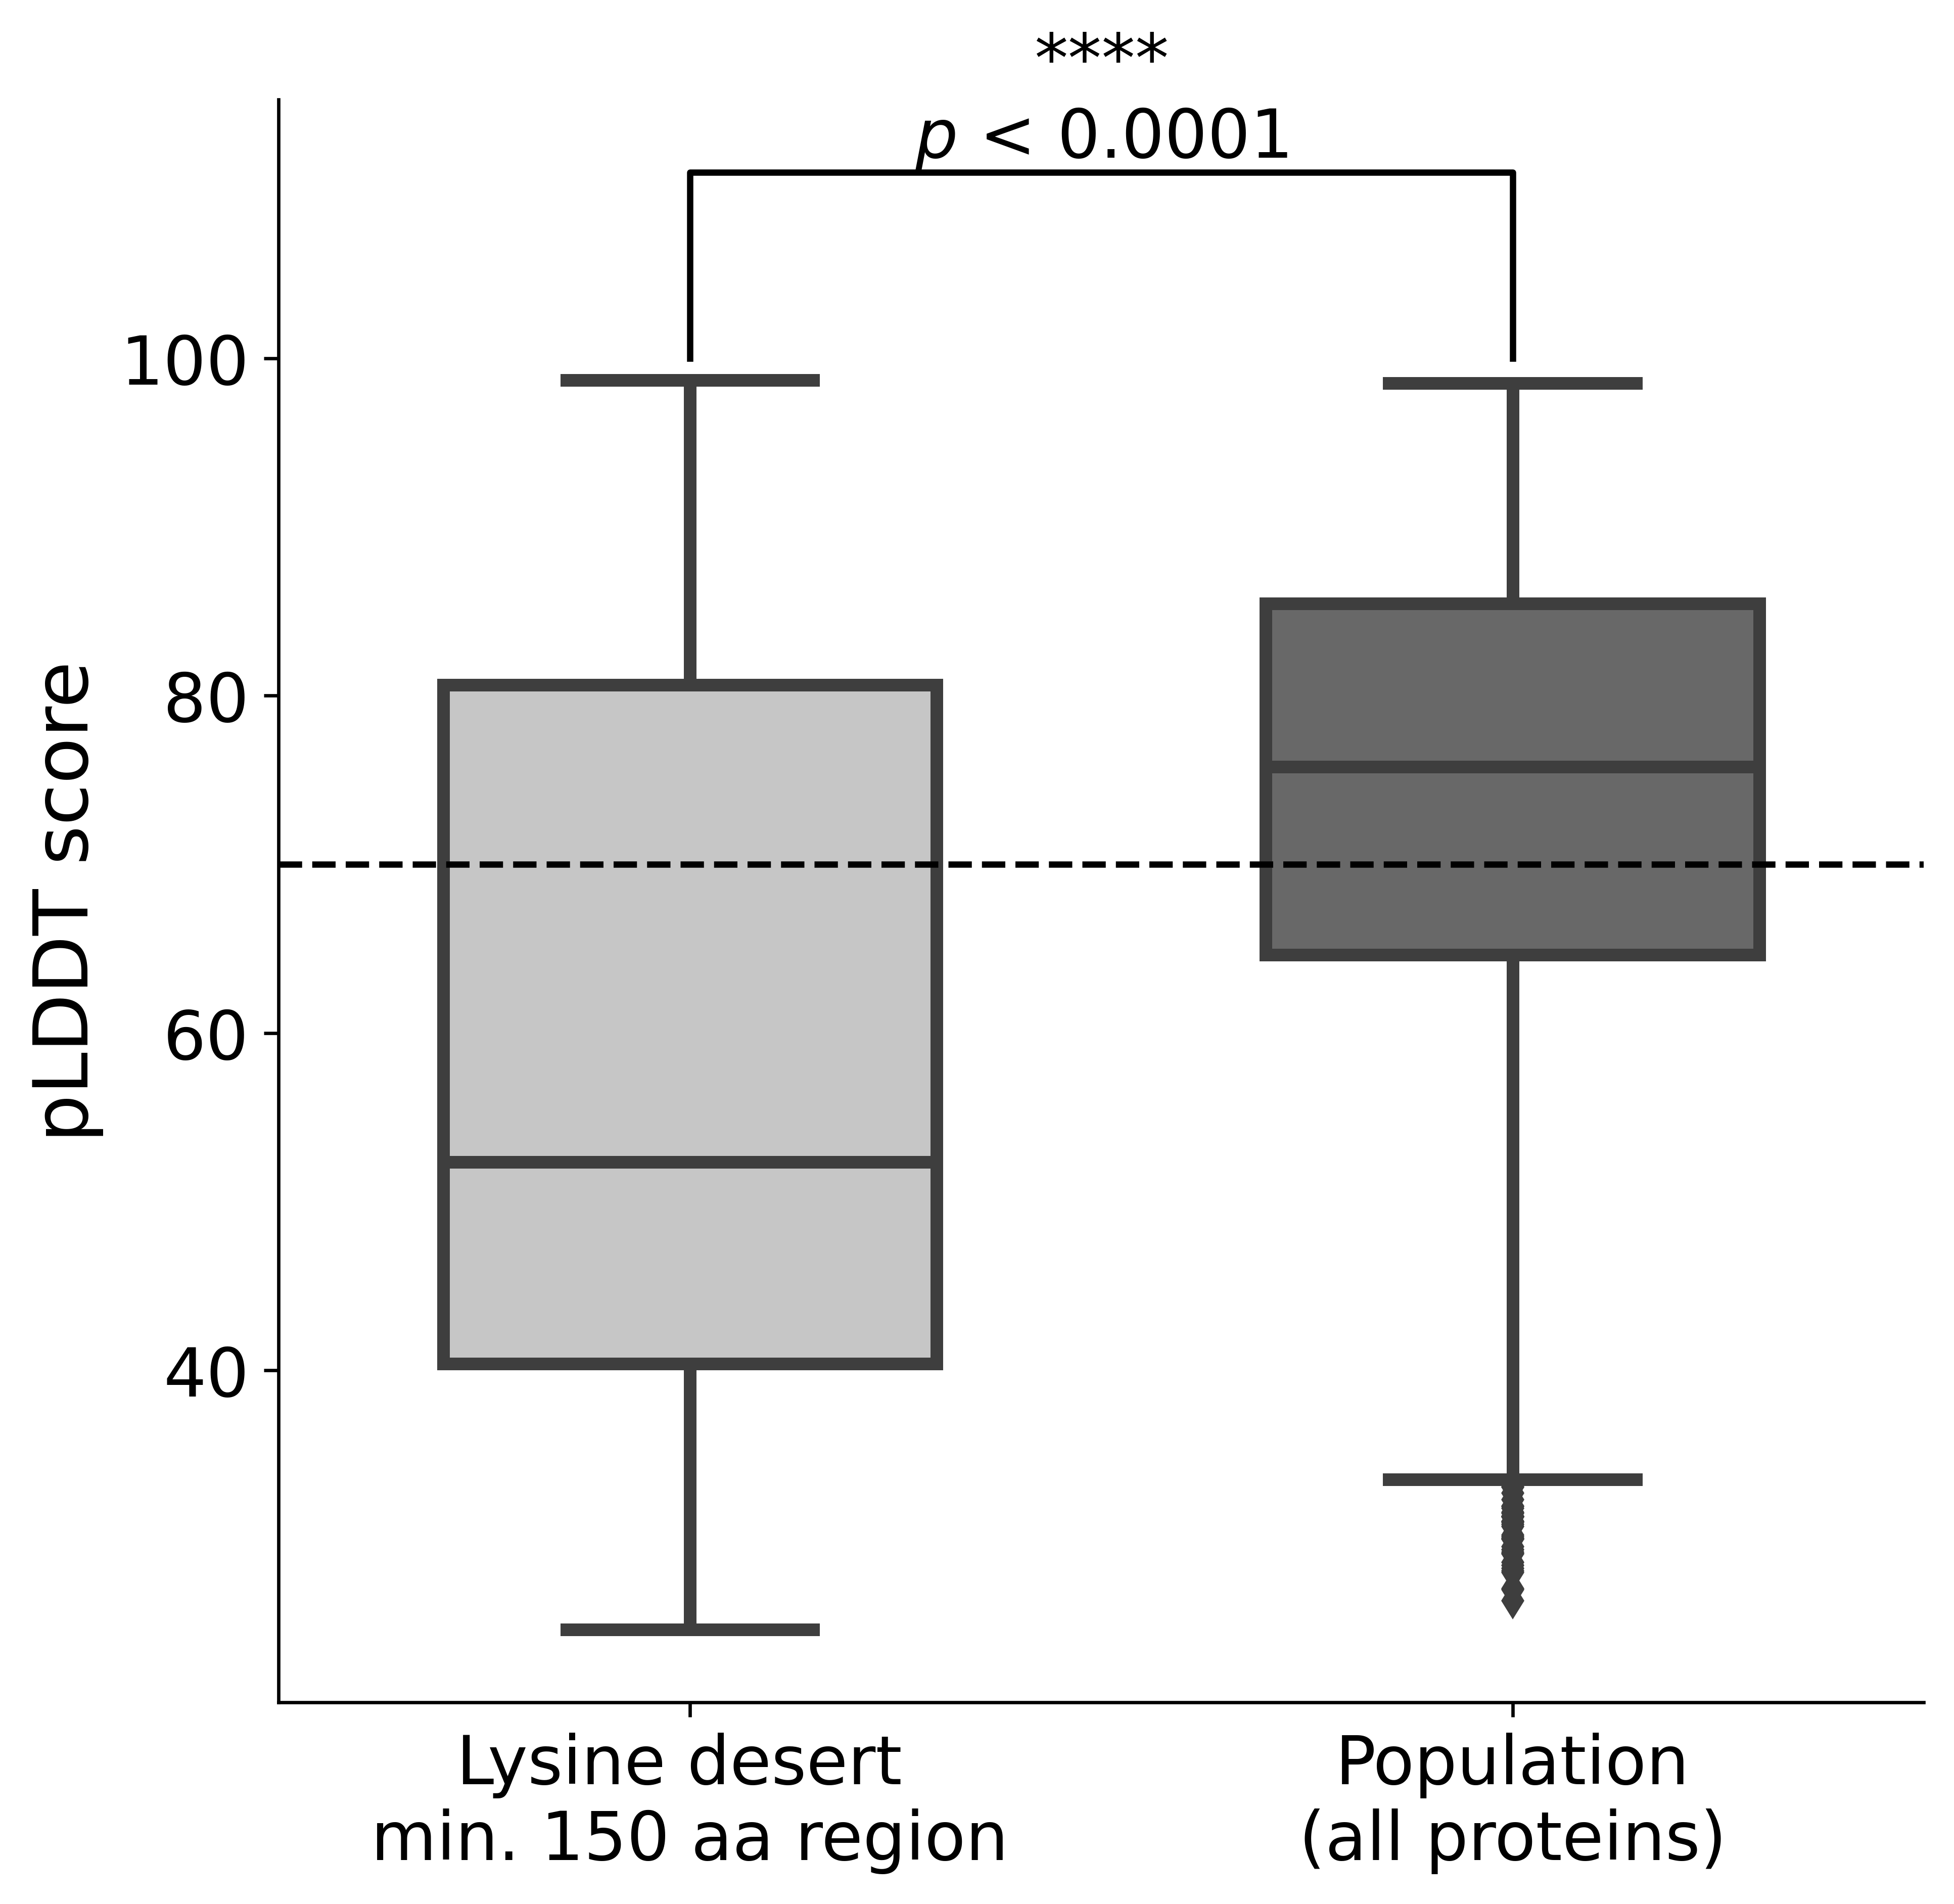

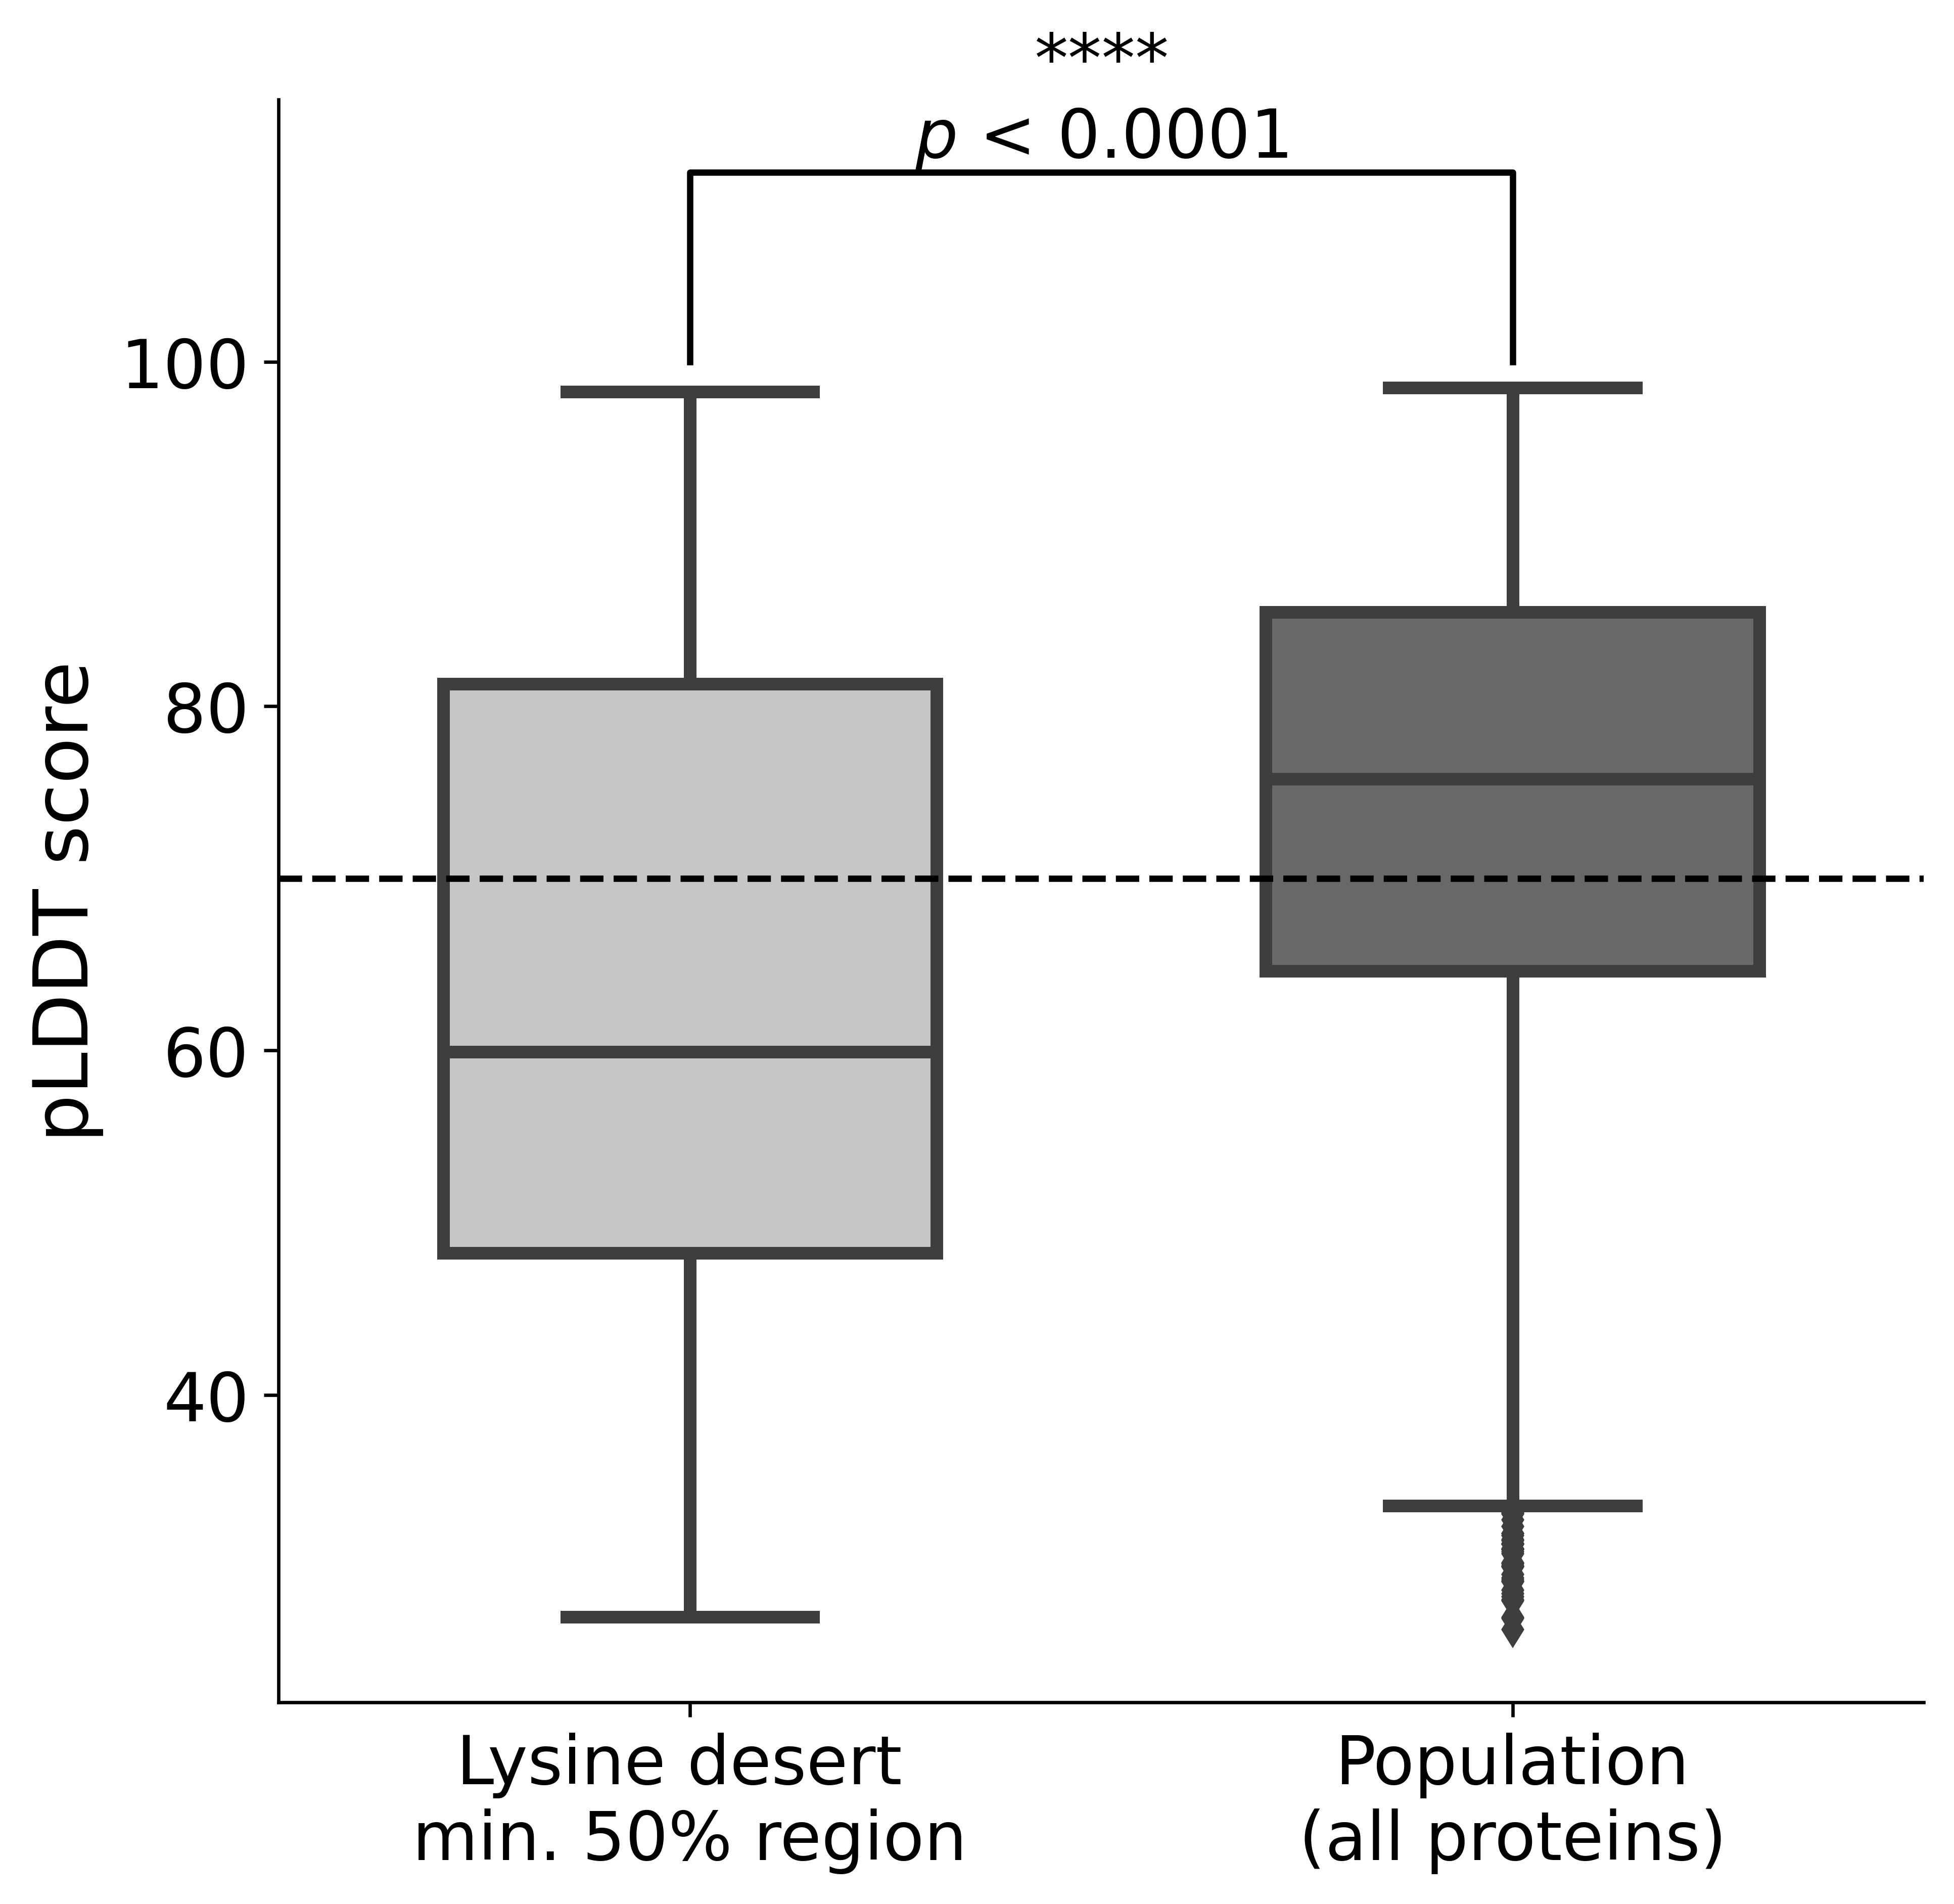

In [114]:
with open('results/plddt_results/plddt_dict.pickle', 'rb') as handle:
    plldt_dict = pickle.load(handle)
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_results = df_results[(df_results["NumTMH"] <= TMH_max) & (df_results["Sequence length"] >=seq_min_length)]

# If only for RING-type E3s
#df_results = df_results [df_results['E3 class'] == 'RING']

for des_length in desert_min_lengths:
    mean_disorder_desert = []
    mean_disorder_population = []
    
    for ident, value in df_results.iterrows():

        uniprot = value[0]
        seq = value[4]
        start = int(value[29])
        end = int(value[30])
        
        if des_length == 150:
            desert = value[21]
            desc_desert = '150 aa'
        elif des_length == 0.5:
            desert = value[22]
            desc_desert = '50%'
        else:
            raise Exception('Unknown desert length')

        if uniprot not in plldt_dict.keys(): continue
        if len(plldt_dict[uniprot]) == 0: continue
        if len(plldt_dict[uniprot]) != len(seq): continue

        if desert == "Yes":
            mean_disorder_desert.append(round(statistics.mean(plldt_dict[uniprot][start:end]),2))

        mean_disorder_population.append(round(statistics.mean(plldt_dict[uniprot]),2))
    
    ### Plot results ###
    plt.rcParams['figure.figsize']=(7,7)
    ax = sns.boxplot(data=[mean_disorder_desert, mean_disorder_population],   width=.6, palette='Greys', linewidth=3)
    
    plt.xticks(plt.xticks()[0], [f'Lysine desert \nmin. {desc_desert} region', 'Population\n(all proteins)'],fontsize=16);
    # If only for RING-type E3s
    #plt.xticks(plt.xticks()[0], [f'Lysine desert \nmin. {desc_desert} region', 'Population\n(all RING E3s)'],fontsize=16);
    
    ax.set_ylabel("pLDDT score",fontsize=18);
    ax.tick_params(labelsize=16)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.axhline(70, c='black', ls='--')
    
    U1, pvalue = mannwhitneyu(mean_disorder_desert, mean_disorder_population)
    pval_round = round(pvalue,4)
    if pvalue > 0.05:
        symbol = 'ns'
        p_text = "$\it{p}$ = " +str(pval_round)
    elif pvalue <= 0.05 and pvalue > 0.01:
        symbol = '*'
        p_text = "$\it{p}$ = " +str(pval_round)
    elif pvalue <= 0.01 and pvalue > 0.001:
        symbol = '**'
        p_text = "$\it{p}$ = " +str(pval_round)
    elif pvalue <= 0.001 and pvalue > 0.0001:
        symbol = '***'
        p_text = "$\it{p}$ = " +str(pval_round)
    else:
        symbol = '****'
        p_text = "$\it{p}$ < 0.0001"

    # statistical annotation
    x1, x2 = 0, 1   
    y, h, col = 100 , 11, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, f"{symbol}\n{p_text}", ha='center', va='bottom', color=col, size=16);
    plt.savefig(f'results/desert_disorder/Afold_desert{des_length}.png', dpi=600, bbox_inches='tight')
    # If only for RING-type E3s
    #plt.savefig(f'results/desert_disorder/Afold_desert_E3_RING_only_{des_length}.png', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close('all')

### Check lysine clusters' disorder within lysine desert proteins

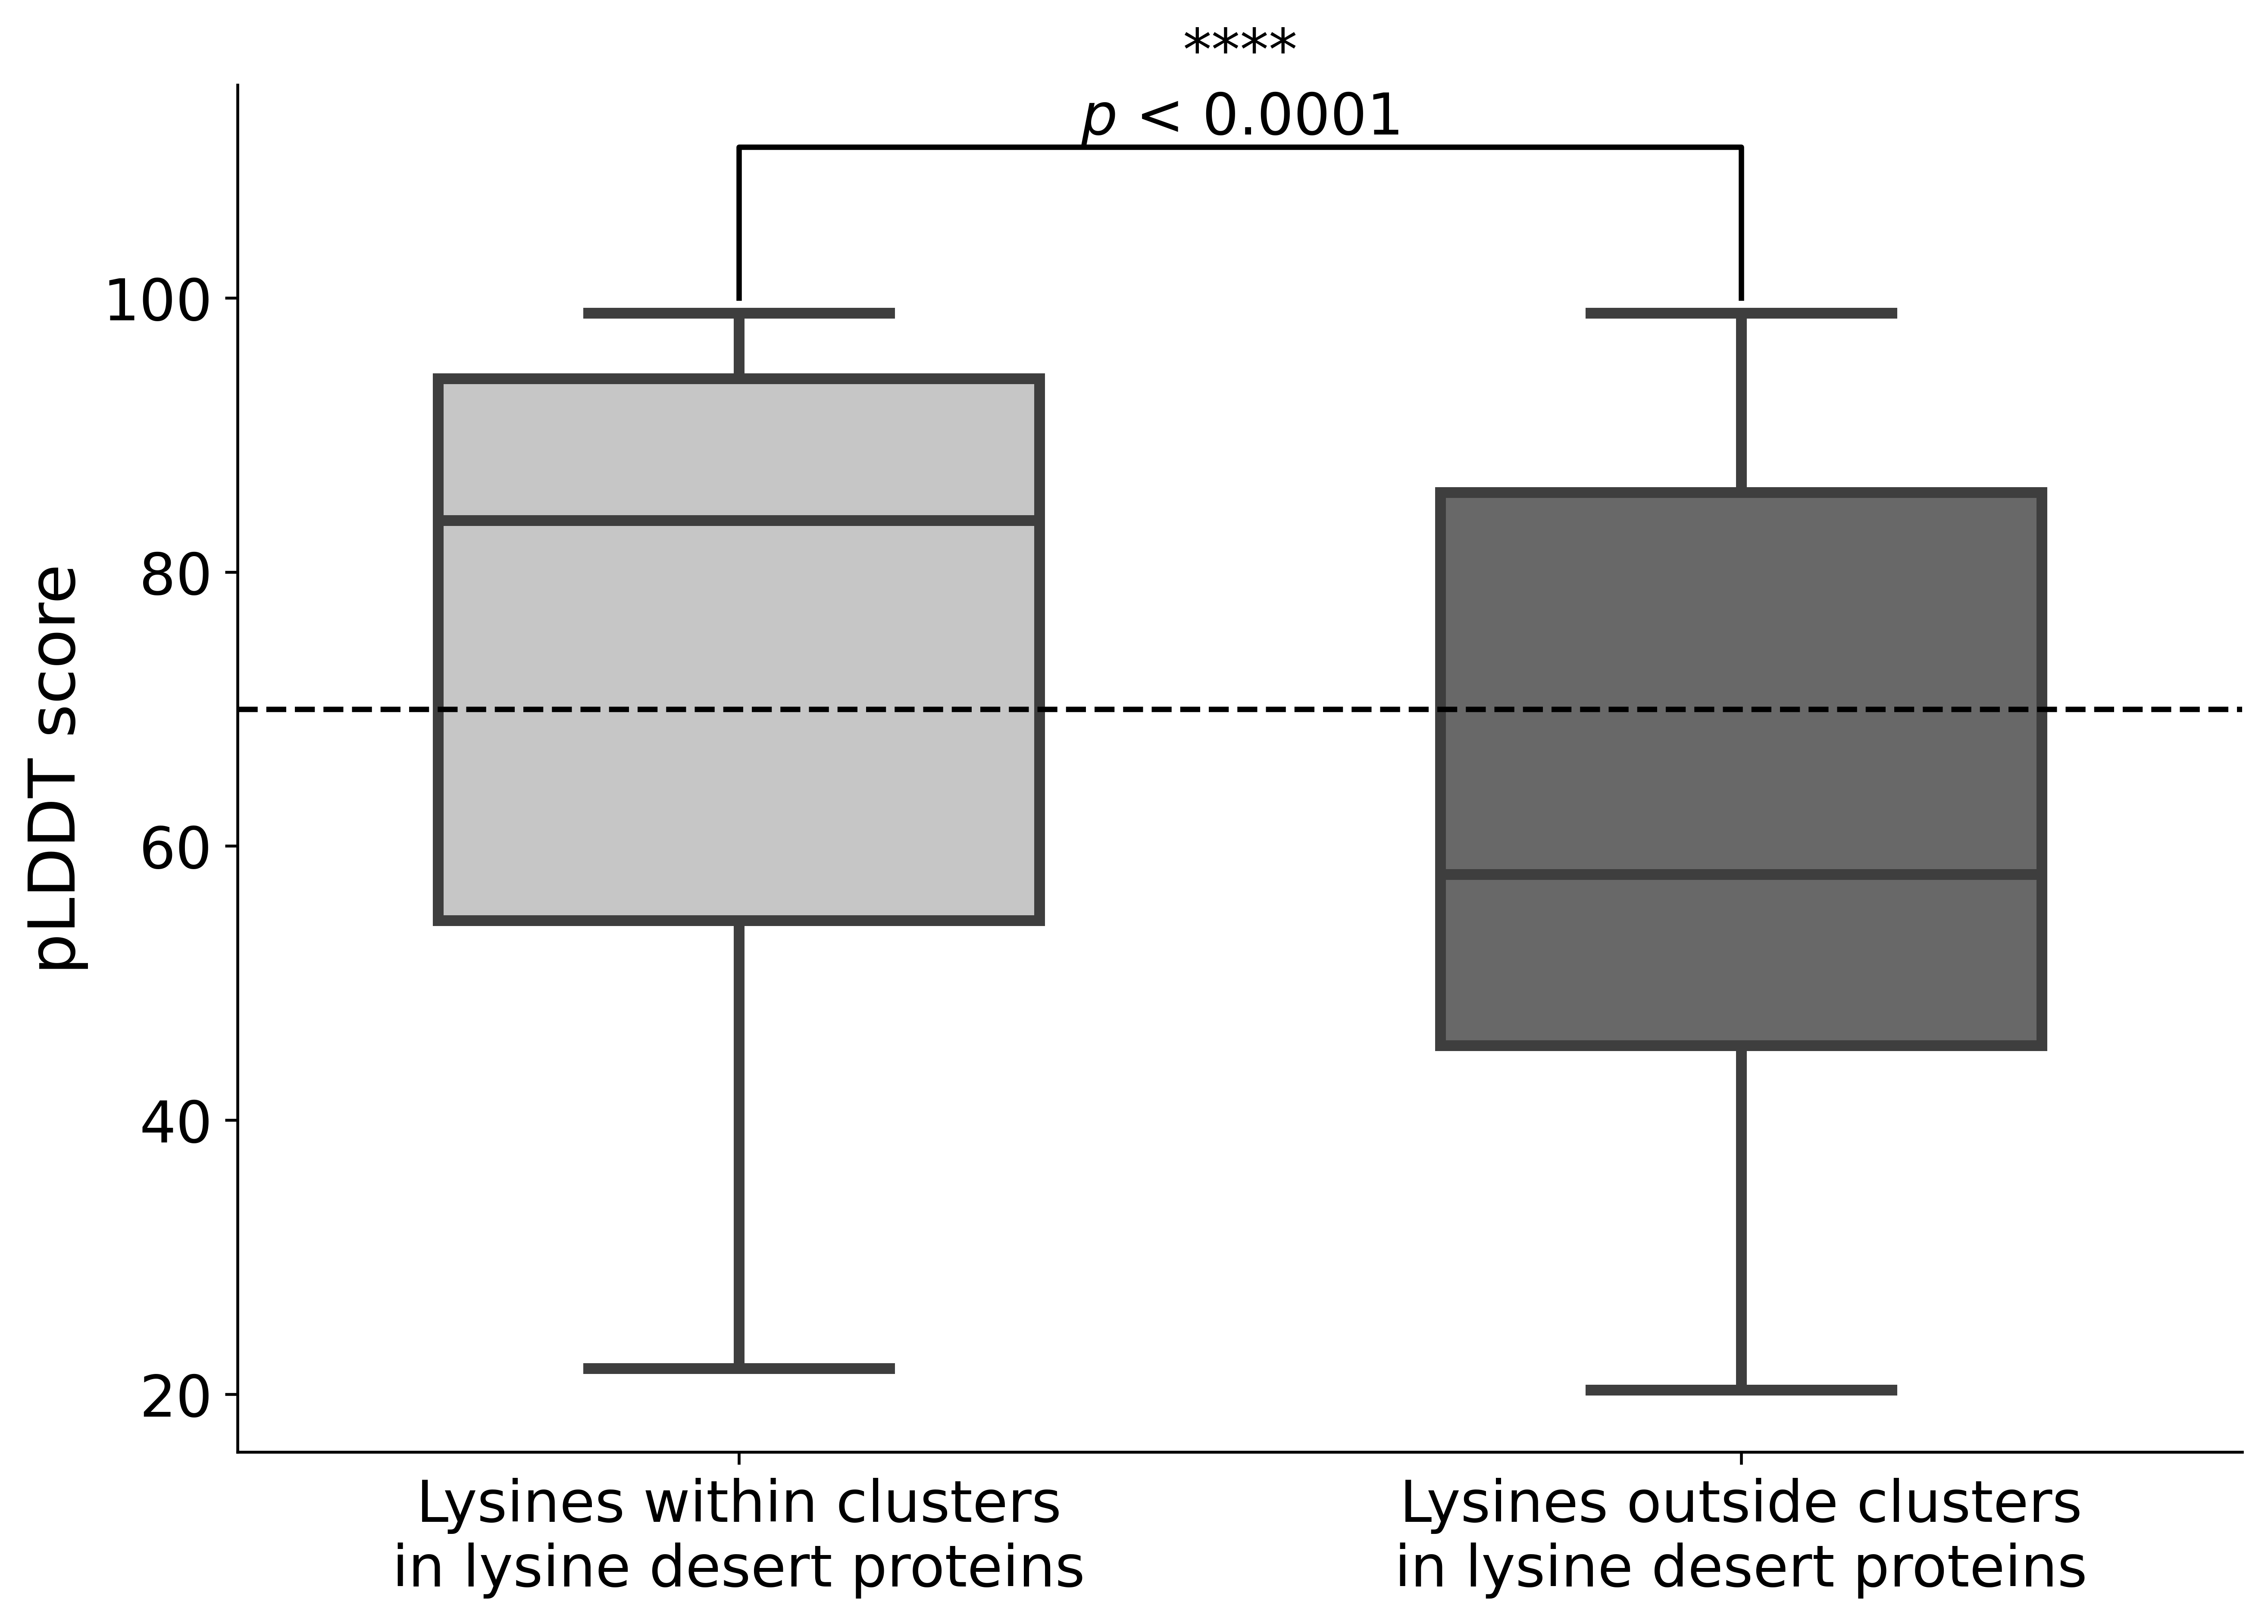

In [110]:
with open('results/plddt_results/plddt_dict.pickle', 'rb') as handle:
    plldt_dict = pickle.load(handle)
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_results = df_results[(df_results["NumTMH"] <= TMH_max) & (df_results["Sequence length"] >=seq_min_length)]

mean_disorder_lyscluster = []
mean_disorder_population_withindesert = []
already_with_desert_uniprots = set()

for des_length in desert_min_lengths:
    for ident, value in df_results.iterrows():

        uniprot = value[0]
        seq = value[4]
        start = int(value[29])
        end = int(value[30])
        cluster_anywhere = value[23]
        
        if des_length == 150:
            desert = value[21]
            desc_desert = '150 aa'
        elif des_length == 0.5:
            desert = value[22]
            desc_desert = '50%'
        else:
            raise Exception('Unknown desert length')

        if uniprot not in plldt_dict.keys(): continue
        if len(plldt_dict[uniprot]) == 0: continue
        if len(plldt_dict[uniprot]) != len(seq): continue

        if desert == "Yes" and cluster_anywhere == 'Yes' and uniprot not in already_with_desert_uniprots:
            left_idx_smallest = int(value[26])
            right_idx_largest = int(value[27])
        
            already_with_desert_uniprots.add(uniprot)
            all_lys_cluster = []
            all_lys_outside_desert_population = []

            for i in range(len(seq)):
                if seq[i] == 'K':
                    if i in range(int(left_idx_smallest), int(right_idx_largest)+1):
                        all_lys_cluster.append(i)
                    else:
                        all_lys_outside_desert_population.append(i)

            for el in all_lys_outside_desert_population:
                mean_disorder_population_withindesert.append(round((plldt_dict[uniprot][el]),2))
            for el in all_lys_cluster:
                mean_disorder_lyscluster.append(round((plldt_dict[uniprot][el]),2))

        else:
            continue

### Plot results ###            
plt.rcParams['figure.figsize']=(10,7)
ax = sns.boxplot(data=[mean_disorder_lyscluster, mean_disorder_population_withindesert],   width=.6, palette='Greys', linewidth=3)
plt.xticks(plt.xticks()[0], [f'Lysines within clusters\nin lysine desert proteins', 'Lysines outside clusters\nin lysine desert proteins'],fontsize=16);

ax.set_ylabel("pLDDT score",fontsize=18);
ax.tick_params(labelsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axhline(70, c='black', ls='--')

U1, pvalue = mannwhitneyu(mean_disorder_lyscluster, mean_disorder_population_withindesert)
pval_round = round(pvalue, 4)
if pvalue > 0.05:
    symbol = 'ns'
    p_text = "$\it{p}$ = " +str(pval_round)
elif pvalue <= 0.05 and pvalue > 0.01:
    symbol = '*'
    p_text = "$\it{p}$ = " +str(pval_round)
elif pvalue <= 0.01 and pvalue > 0.001:
    symbol = '**'
    p_text = "$\it{p}$ = " +str(pval_round)
elif pvalue <= 0.001 and pvalue > 0.0001:
    symbol = '***'
    p_text = "$\it{p}$ = " +str(pval_round)
else:
    symbol = '****'
    p_text = "$\it{p}$ < 0.0001"

# statistical annotation
x1, x2 = 0, 1   
y, h, col = 100 , 11, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, f"{symbol}\n{p_text}", ha='center', va='bottom', color=col, size=16);
plt.savefig(f'results/lyscluster_disorder/lysine_clusters_among_deserts_AFOLD.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close('all')

Delete unnecessary files

In [ ]:
%%bash

rm -r data/human_proteome_single_seq/

## 6.3. GO Terms over-representation analysis

### 6.3.1. Prepare datasets

In [6]:
%%bash

mkdir -p results/GO_Terms
mkdir -p results/GO_Terms/inputs
mkdir -p results/GO_Terms/inputs/populations
mkdir -p results/GO_Terms/inputs/subpopulations
mkdir -p results/GO_Terms/inputs/subpopulations/150
mkdir -p results/GO_Terms/inputs/subpopulations/0.5

mkdir -p results/GO_Terms/0.5/lysine_deserts
mkdir -p results/GO_Terms/0.5/lysine_deserts_with_lysine_cluster
mkdir -p results/GO_Terms/150/lysine_deserts
mkdir -p results/GO_Terms/150/lysine_deserts_with_lysine_cluster

In [7]:
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_results = df_results[(df_results["NumTMH"] <= TMH_max) & (df_results["Sequence length"] >=seq_min_length)]

#### Prepare population

The population will be the entire human proteome of sequences ≥ 150 aa and with the predicted number of transmembrane helices ≤ 2.

In [8]:
all_genes = df_results['Gene symbol'].values
with open('results/GO_Terms/inputs/populations/all_human_genes.txt', 'w') as f:
    for item in all_genes:
        if type(item) is str:
            f.write("%s\n" % item.split(';')[0])

#### Prepare subpopulations

For each lysine desert length, prepare the following subpopulations:

- proteins with present lysine desert
- proteins with present lysine desert and lysine cluster

In [43]:
subpop_150_1 = df_results[df_results['Lysine desert 150'] == 'Yes']['Gene symbol'].values
subpop_150_2 = df_results[(df_results['Lysine desert 150'] == 'Yes') & (df_results['Lysine cluster anywhere'] == 'Yes')]['Gene symbol'].values

with open('results/GO_Terms/inputs/subpopulations/150/lysine_desert_150.txt', 'w') as f:
    for item in subpop_150_1:
        if type(item) is str:
            f.write("%s\n" % item.split(';')[0])
with open('results/GO_Terms/inputs/subpopulations/150/lysine_desert_150_lys_cluster.txt', 'w') as f:
    for item in subpop_150_2:
        if type(item) is str:
            f.write("%s\n" % item.split(';')[0])
            
subpop_05_1 = df_results[df_results['Lysine desert 0.5'] == 'Yes']['Gene symbol'].values
subpop_05_2 = df_results[(df_results['Lysine desert 0.5'] == 'Yes') & (df_results['Lysine cluster anywhere'] == 'Yes')]['Gene symbol'].values

with open('results/GO_Terms/inputs/subpopulations/0.5/lysine_desert_0.5.txt', 'w') as f:
    for item in subpop_05_1:
        if type(item) is str:
            f.write("%s\n" % item.split(';')[0])
with open('results/GO_Terms/inputs/subpopulations/0.5/lysine_desert_0.5_lys_cluster.txt', 'w') as f:
    for item in subpop_05_2:
        if type(item) is str:
            f.write("%s\n" % item.split(';')[0])

### 6.3.2. Perform GO Terms over-representation analyses

Run the Molecular Function GO Terms over-representation analyses using the [WebGestalt webserver](http://www.webgestalt.org).


**Population:** filtered human proteome from `results/GO_Terms/inputs/populations/all_human_genes.txt`

**Subpopulations:**

* proteins with present lysine desert (min. 150 aa/min 50%)
* proteins with present lysine desert and lysine cluster (150/0.5)


### Parameters

#### Basic Parameters

* **Organism of Interest:** Homo sapiens
* **Method of Interest:** Over-Representation Analysis (ORA)
* **Functional Database:** geneontology
* Select a function database name as: Biological Process/Molecular Function/Cellular Component, separately for each analysis

#### Gene List

* **Select Gene ID Type:** Gene Symbol
* Upload the desired subpopulation in Upload Gene List field

#### Reference Gene List

* Select ID type as Gene symbol
* Upload the population in the Upload User Reference Set File Select ID type field

---

### Save the results

1. Click download data

2. Save the downloaded directory as `webgastalt_results` to appropriate, according to the analyzed subpopulation, subdirectory of `results/GO_Terms`.

### 6.3.4. Visualize the results using REViGO webserver


1. Cut p-values

    From each `webgastalt_results/enrichment_results_XX.txt` file, cut p-values for GO Terms with FDR < 0.05, e.g. (in bash)

    `tail -n+2 enrichment_results_XX.txt | LC_ALL=C awk -v FS='\t' '$9+0<0.05 { print $1,$8 }'`
    

2. Copy the output and paste it in the [REViGO webserver](http://revigo.irb.hr)

3. Run with the default parameters, except for the option "What species would you like to work with" - change it to Homo sapiens.

4. Choose tab Treemap and downloadR script for plotting treemaps

5. Open downloaded R script and run it (you can custom the display parameters), save the generated tree map and R script to appropriate, according to the analyzed subpopulation, subdirectory of `results/GO_Terms`.

## 6.4. Check correlation between length of lysine-less region and half-life

### 6.4.1. Prepare datasets

#### Prepare dataset from Mathieson *et al*

In [9]:
# Read xlsx file into a dataframe
data_xlsx_mathieson = pd.read_excel('data/half_life/Mathieson_half_life_dataset.xlsx', 'protein half lives high qual', index_col=None)

# Replace all fields having line breaks with space
df_mathieson = data_xlsx_mathieson.replace('\n', ' ', regex=True)
df_mathieson.rename(columns={'gene_name':'Gene symbol'}, inplace=True)
df_mathieson.drop(df_mathieson.columns[[-1,-2,-3,-4,-5,-6]], axis=1, inplace=True)
df_mathieson.dropna(subset = ['Bcells replicate 1 dataQual', 'Bcells replicate 2 dataQual',
                             'NK cells replicate 1 dataQual', 'NK cells replicate 2 dataQual',
                             'Hepatocytes replicate 1 dataQual', 'Hepatocytes replicate 2 dataQual',
                             'Monocytes replicate 1 dataQual', 'Monocytes replicate 2 dataQual'], 
                    how='all', inplace=True)

df_mathieson.head()

Gene symbol  Bcells replicate 1 half_life Bcells replicate 1 dataQual  \
0         A2M                           NaN                         NaN   
1        AAAS                        75.299                        good   
2        AACS                           NaN                         NaN   
3        AAK1                           NaN                         NaN   
4       AAMDC                           NaN                         NaN   

   Bcells replicate 1 R_sq  Bcells replicate 2 half_life  \
0                      NaN                           NaN   
1                    0.982                        88.376   
2                      NaN                        30.524   
3                      NaN                           NaN   
4                      NaN                           NaN   

  Bcells replicate 2 dataQual  Bcells replicate 2 R_sq  \
0                         NaN                      NaN   
1                        good                    0.990   
2                        weak                    0.995   
3                         NaN                      NaN   
4                         NaN                      NaN   

   NK cells replicate 1 half_life NK cells replicate 1 dataQual  \
0                             NaN                           NaN   
1                         379.453                          good   
2                             NaN                           NaN   
3                             NaN                           NaN   
4                             NaN                           NaN   

   NK cells replicate 1 R_sq  NK cells replicate 2 half_life  \
0                        NaN                             NaN   
1                      0.961                         208.182   
2                        NaN                          98.574   
3                        NaN                         152.678   
4                        NaN                             NaN   

  NK cells replicate 2 dataQual  NK cells replicate 2 R_sq  \
0                           NaN                        NaN   
1                          good                      0.992   
2                          weak                      0.973   
3                          good                      0.984   
4                           NaN                        NaN   

   Hepatocytes replicate 1 half_life Hepatocytes replicate 1 dataQual  \
0                             23.674                             good   
1                                NaN                              NaN   
2                                NaN                              NaN   
3                                NaN                              NaN   
4                                NaN                              NaN   

   Hepatocytes replicate 1 R_sq  Hepatocytes replicate 2 half_life  \
0                         0.885                             24.377   
1                           NaN                            145.343   
2                           NaN                                NaN   
3                           NaN                                NaN   
4                           NaN                                NaN   

  Hepatocytes replicate 2 dataQual  Hepatocytes replicate 2 R_sq  \
0                             good                         0.905   
1                             weak                         0.852   
2                              NaN                           NaN   
3                              NaN                           NaN   
4                              NaN                           NaN   

   Monocytes replicate 1 half_life Monocytes replicate 1 dataQual  \
0                           14.599                           weak   
1                           78.090                           weak   
2                           69.614                           weak   
3                           76.276                           weak   
4                           68.136                           weak 

#### Calculate average half-lives

For each cell type, calculate mean half-life from 2 replicates, if applicable.

> **_NOTE:_** Sometimes half-life for protein in particular cell type is not reported or is reported only for one replicate, in the latter case we will use only one reported half-life value.

In [6]:
df_mathieson['Bcells mean half_life'] = df_mathieson[['Bcells replicate 1 half_life', 
                                                      'Bcells replicate 2 half_life']].mean(axis=1).round(2)
df_mathieson['NK cells mean half_life'] = df_mathieson[['NK cells replicate 1 half_life', 
                                                        'NK cells replicate 2 half_life']].mean(axis=1).round(2)
df_mathieson['Hepatocytes mean half_life'] = df_mathieson[['Hepatocytes replicate 1 half_life', 
                                                           'Hepatocytes replicate 2 half_life']].mean(axis=1).round(2)
df_mathieson['Monocytes mean half_life'] = df_mathieson[['Monocytes replicate 1 half_life', 
                                                         'Monocytes replicate 2 half_life']].mean(axis=1).round(2)

#### Prepare dataset from Li *et al*

In [10]:
data_xlsx_li_sheet1 = pd.read_excel('data/half_life/Li_half_life_dataset.xlsx', 'U2OS', index_col=None)
data_xlsx_li_sheet2 = pd.read_excel('data/half_life/Li_half_life_dataset.xlsx', 'HEK293T', index_col=None)
data_xlsx_li_sheet3 = pd.read_excel('data/half_life/Li_half_life_dataset.xlsx', 'HCT116', index_col=None)
data_xlsx_li_sheet4 = pd.read_excel('data/half_life/Li_half_life_dataset.xlsx', 'RPE1', index_col=None)

data_xlsx_li_sheet1.rename(columns={'Half-life':'U2OS Half-life'}, inplace=True)
data_xlsx_li_sheet1.drop(data_xlsx_li_sheet1.columns[range(1,19)], axis=1, inplace=True)
data_xlsx_li_sheet1.drop(data_xlsx_li_sheet1.columns[[2,3]], axis=1, inplace=True)
data_xlsx_li_sheet2.rename(columns={'Half-life':'HEK293T Half-life'}, inplace=True)
data_xlsx_li_sheet2.drop(data_xlsx_li_sheet2.columns[range(1,19)], axis=1, inplace=True)
data_xlsx_li_sheet2.drop(data_xlsx_li_sheet2.columns[[2,3]], axis=1, inplace=True)
data_xlsx_li_sheet3.rename(columns={'Half-life':'HCT116 Half-life'}, inplace=True)
data_xlsx_li_sheet3.drop(data_xlsx_li_sheet3.columns[range(1,19)], axis=1, inplace=True)
data_xlsx_li_sheet3.drop(data_xlsx_li_sheet3.columns[[2,3]], axis=1, inplace=True)
data_xlsx_li_sheet4.rename(columns={'Half-life':'RPE1 Half-life'}, inplace=True)
data_xlsx_li_sheet4.drop(data_xlsx_li_sheet4.columns[range(1,19)], axis=1, inplace=True)
data_xlsx_li_sheet4.drop(data_xlsx_li_sheet4.columns[[2,3]], axis=1, inplace=True)

li_all = pd.merge(data_xlsx_li_sheet1, data_xlsx_li_sheet2, on='Uniprot ID',how='outer')
li_all = pd.merge(li_all, data_xlsx_li_sheet3,  on='Uniprot ID',how='outer')
li_all = pd.merge(li_all, data_xlsx_li_sheet4,  on='Uniprot ID',how='outer')
li_all.rename({'Uniprot ID':'UniProtID'}, axis=1, inplace=True)
li_all.head()

UniProtID  U2OS Half-life  HEK293T Half-life  HCT116 Half-life  \
0    Q9Y3B1            0.34                0.3              0.33   
1    Q96E09            0.43                NaN               NaN   
2    P30279            0.43                NaN               NaN   
3    Q9Y6B2            0.43                0.6               NaN   
4    Q8NA92            0.46                NaN               NaN   

   RPE1 Half-life  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

### 6.4.2. Merge both half-life datasets with the dataset of lysine deserts' occurrence in the human proteome

In [8]:
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_results['Lysine desert sequence fraction'] = df_results['Lysine desert sequence fraction'].apply(lambda x: x*100)
merged = pd.merge(df_results, df_mathieson, on='Gene symbol',how='outer')
merged = pd.merge(merged, li_all, on='UniProtID',how='outer')
merged.dropna(subset = ["Sequence"], inplace=True)
merged.head()

UniProtID Gene symbol All gene symbols HK gene  \
0  A0A087X1C5      CYP2D7           CYP2D7      No   
1  A0A0B4J2F0     PIGBOS1          PIGBOS1      No   
2  A0A0B4J2F2       SIK1B            SIK1B      No   
3  A0A0C5B5G6     MT-RNR1          MT-RNR1      No   
4  A0A0K2S4Q6      CD300H           CD300H      No   

                                            Sequence  Sequence length  \
0  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...            515.0   
1  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...             54.0   
2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...            783.0   
3                                   MRWQEMGYIFYPRKLR             16.0   
4  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...            201.0   

                                Subcellular location  \
0  Membrane;Multi-pass membrane protein;Cytoplasm...   
1  Mitochondrion outer membrane;Single-pass membr...   
2                                                NaN   
3                     Secreted;Mitochondrion;Nucleus   
4  Membrane;Single-pass type I membrane protein;S...   

                                            Function  \
0  FUNCTION: May be responsible for the metabolis...   
1  FUNCTION: Plays a role in regulation of the un...   
2  FUNCTION: Probable serine/threonine-protein ki...   
3  FUNCTION: Regulates insulin sensitivity and me...   
4  FUNCTION: May play an important role in innate...   

                               GO:Biological Process  \
0  arachidonic acid metabolic process;organic aci...   
1  regulation of endoplasmic reticulum unfolded p...   
2  cellular response to glucose starvation;intrac...   
3  activation of protein kinase activity;negative...   
4                              neutrophil chemotaxis   

                               GO:Molecular Function  \
0  aromatase activity;heme binding;iron ion bindi...   
1                                                NaN   
2  ATP binding;magnesium ion binding;protein seri...   
3  DNA binding;DNA-binding transcription factor b...   
4          transmembrane signaling receptor activity   

                               GO:Cellular Component Pathway  \
0  cytoplasm;integral component of membrane;intra...     NaN   
1  integral component of mitochondrial outer memb...     NaN   
2                                          cytoplasm     NaN   
3          extracellular space;mitochondrion;nucleus     NaN   
4  extracellular region;integral component of mem...     NaN   

                                              Tissue Disease  \
0  TISSUE SPECIFICITY: Expressed in brain cortex ...     NaN   
1                                                NaN     NaN   
2                                                NaN     NaN   
3  TISSUE SPECIFICITY: Detected in plasma (at pro...     NaN   
4  TISSUE SPECIFICITY: Expressed on CD16+ monocyt...     NaN   

                                            Families  \
0                             Cytochrome P450 family   
1                                                NaN   
2  Protein kinase superfamily, CAMK Ser/Thr prote...   
3                                                NaN   
4                                       CD300 family   

                                         Interactors  \
0                                                NaN   
1                                   CHLORIDE(Q96S66)   
2  DNA(Q9BRT9);LIM/HOMEOBOX(Q68G74);LRP(Q14696);P...   
3                                                NaN   
4                                                NaN   

           Protein existence  PDB                    IDR_region_start..end  \
0                  Uncertain  NaN      0..3,143..147,228..228,330..347,516   
1  Evidence at protein level  NaN                                  0..5,54   
2                  Uncertain  NaN                  0..20,281..302,353..783   
3  Evidence at protein level  NaN                                  0..5,16   
4  Evidence at protein level  NaN  0..23,63..80,116..126,1

### 6.4.3. Check correlation

In [ ]:
%%bash

mkdir -p results/half_lives/charts/percentages
mkdir -p results/half_lives/charts/nominals
mkdir -p results/supplementary

In [11]:
def make_plot(df_input, x, y, title, dataset_name, xlabel, out):
    
    # Drop rows with no half-lives values or no mapped sequence
    df = df_input[df_input[y].notna()]
    df = df[df['Sequence length'].notna()]

    # Filter out sequences shorther than 150 aa
    df['Sequence length']=df['Sequence length'].astype('int64')
    df = df[(df['Sequence length'] >= seq_min_length) & (df["NumTMH"] <= TMH_max) ]
    
    # Filter out outlier half-lives values
    q_low = df[y].quantile(0.01)
    q_hi  = df[y].quantile(0.99)
    df = df[(df[y] < q_hi) & (df[y] > q_low)]
    plt.rcParams['figure.figsize']=(10,5)        
    g = sns.scatterplot(data=df, x=x, y=y);

    #g.set_title(title, weight="bold")
    g.text(x=0.5, y=1.08, s=title, fontsize=16, weight='bold', ha='center', va='bottom', transform=g.transAxes)
    g.text(x=0.5, y=1.03, s=dataset_name, fontsize=8, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)

    g.set_xlabel(xlabel)
    g.set_ylabel("Half-life [h]")
    if out == 'percentages':
        g.set_xticks(range(0,120,20))
    else:
        if dataset_name == "Li $\it{et}$ $\it{al.}$":
            g.set_xticks(range(0,900,100))
        else:
            g.set_xticks(range(0,1200,100))
    fig = g.get_figure()
    
    corr, _ = spearmanr(df[x], df[y])
    plt.figtext(0.5, -0.08, "Spearman correlation=%.4f" % corr, ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":3})

    plt.show()
    fig.savefig(f"results/half_lives/charts/{out}/{x}_{y}.png", dpi=600, bbox_inches="tight")
    plt.close()


#### Correlation for the lysine-less region defined as sequence fraction

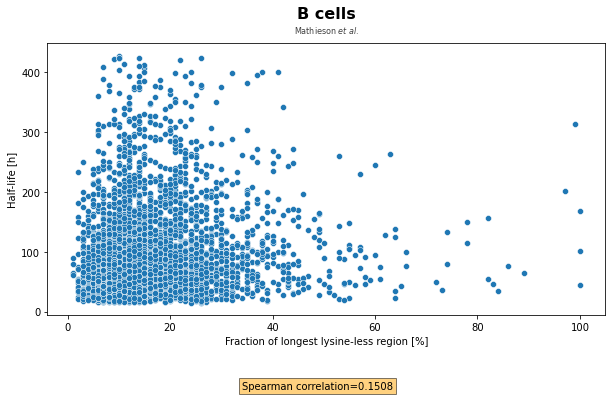

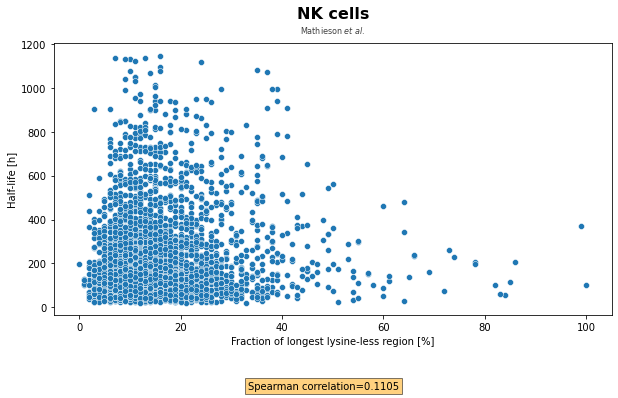

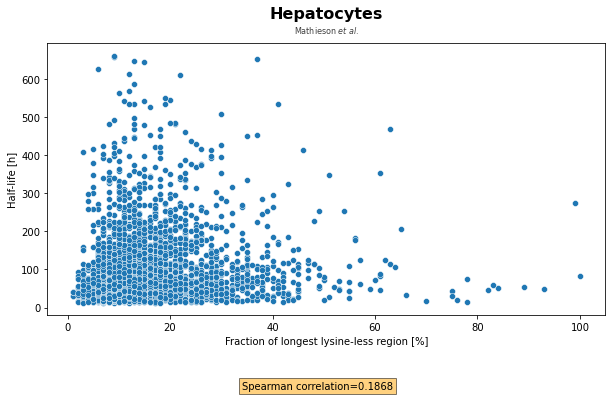

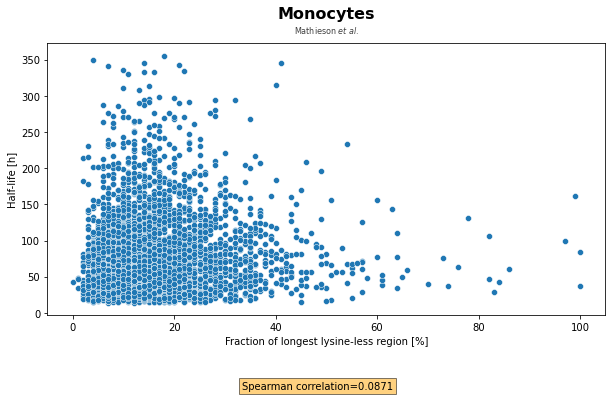

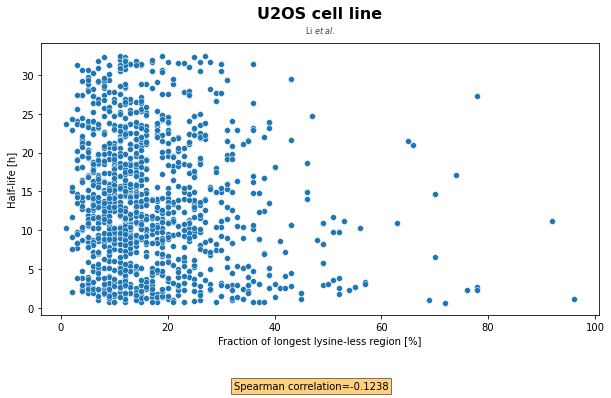

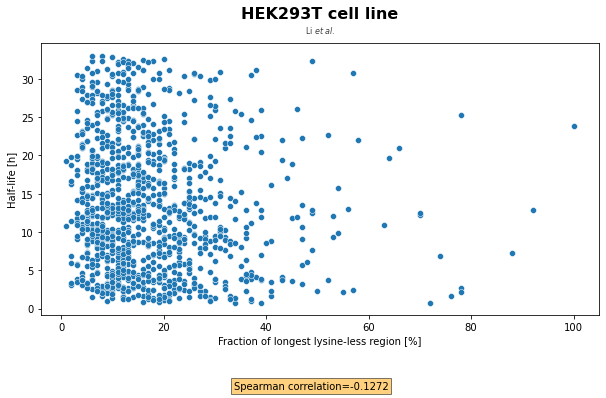

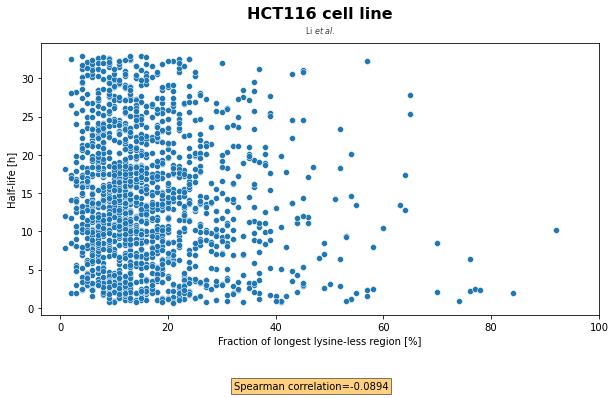

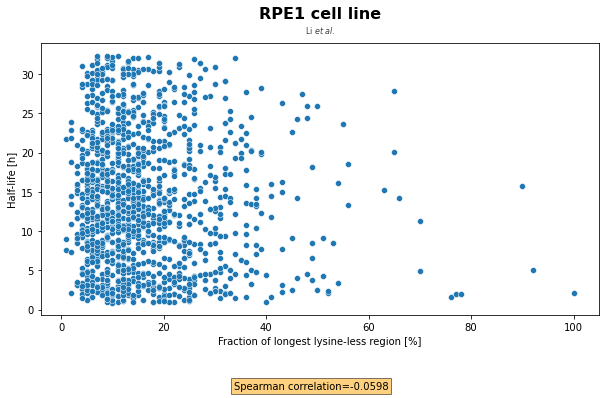

In [12]:
make_plot(merged, 'Lysine desert sequence fraction', 'Bcells mean half_life', 
          "B cells", "Mathieson $\it{et}$ $\it{al.}$", "Fraction of longest lysine-less region [%]", 'percentages')
make_plot(merged, 'Lysine desert sequence fraction', 'NK cells mean half_life', 
          "NK cells", "Mathieson $\it{et}$ $\it{al.}$","Fraction of longest lysine-less region [%]", 'percentages')
make_plot(merged, 'Lysine desert sequence fraction', 'Hepatocytes mean half_life', 
          "Hepatocytes", "Mathieson $\it{et}$ $\it{al.}$","Fraction of longest lysine-less region [%]", 'percentages')
make_plot(merged, 'Lysine desert sequence fraction', 'Monocytes mean half_life', 
          "Monocytes", "Mathieson $\it{et}$ $\it{al.}$","Fraction of longest lysine-less region [%]", 'percentages')

make_plot(merged, 'Lysine desert sequence fraction', 'U2OS Half-life', 
          "U2OS cell line", "Li $\it{et}$ $\it{al.}$","Fraction of longest lysine-less region [%]", 'percentages')
make_plot(merged, 'Lysine desert sequence fraction', 'HEK293T Half-life', 
          "HEK293T cell line", "Li $\it{et}$ $\it{al.}$","Fraction of longest lysine-less region [%]", 'percentages')
make_plot(merged, 'Lysine desert sequence fraction', 'HCT116 Half-life', 
          "HCT116 cell line","Li $\it{et}$ $\it{al.}$","Fraction of longest lysine-less region [%]", 'percentages')
make_plot(merged, 'Lysine desert sequence fraction', 'RPE1 Half-life', 
          "RPE1 cell line", "Li $\it{et}$ $\it{al.}$","Fraction of longest lysine-less region [%]", 'percentages')

#### Correlation for the lysine-less region defined as nominal value

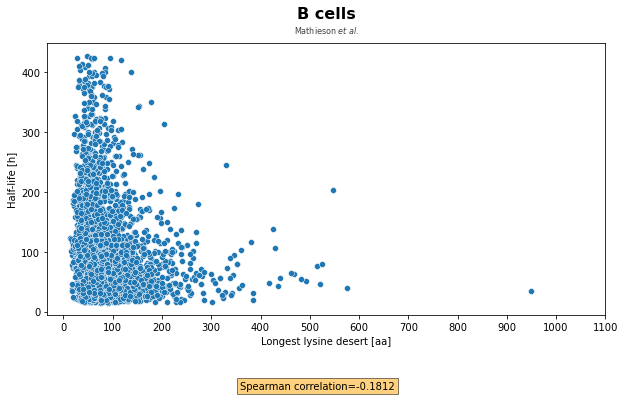

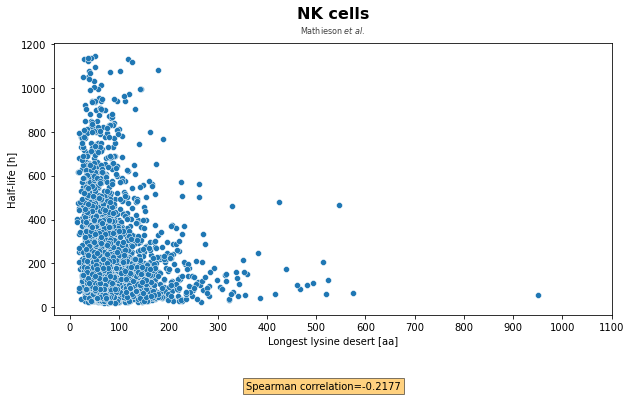

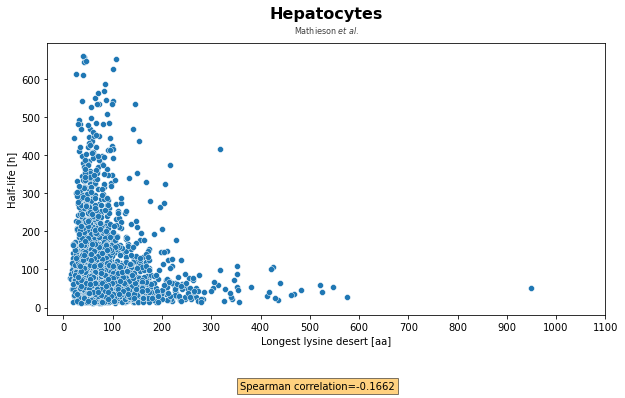

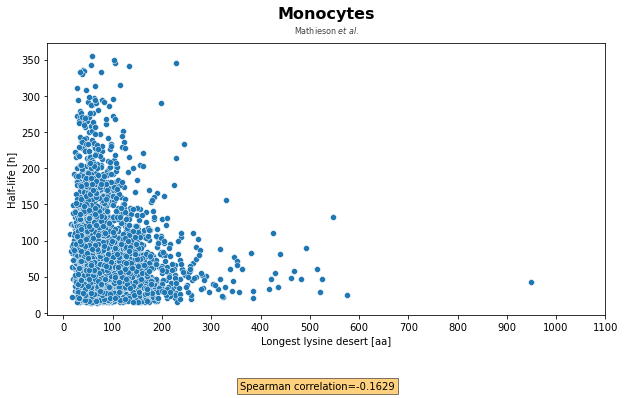

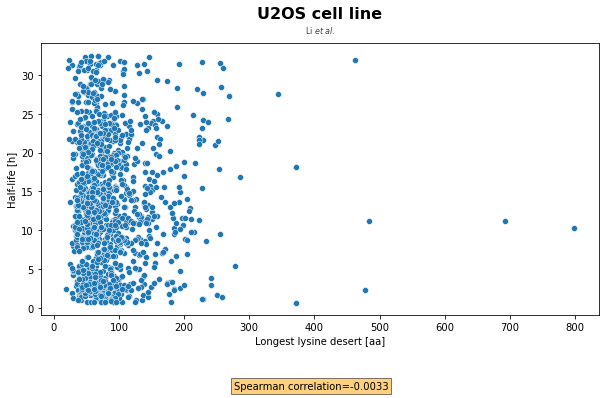

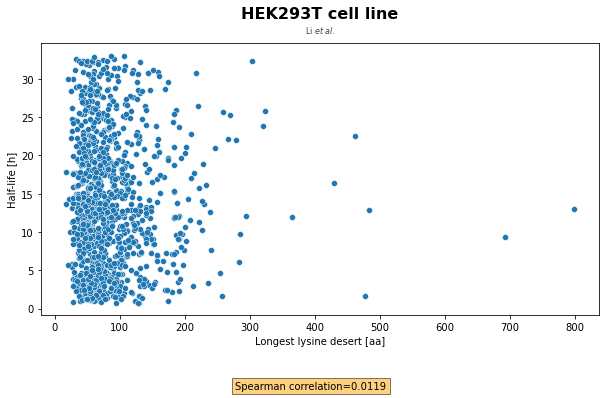

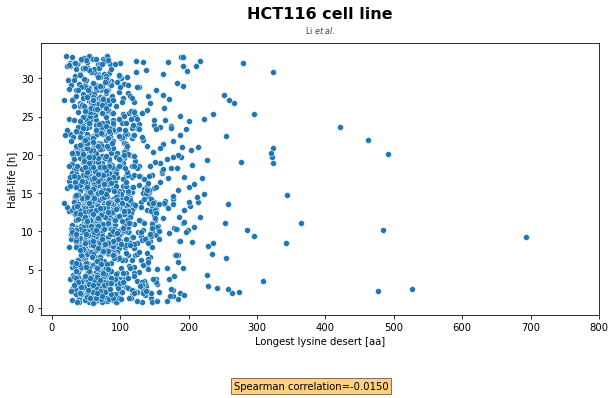

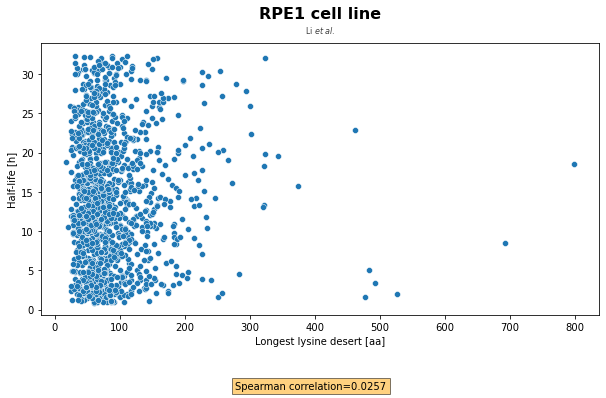

In [13]:
make_plot(merged, 'Longest lysine desert', 'Bcells mean half_life', 
          "B cells", "Mathieson $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')
make_plot(merged, 'Longest lysine desert', 'NK cells mean half_life', 
          "NK cells", "Mathieson $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')
make_plot(merged, 'Longest lysine desert', 'Hepatocytes mean half_life', 
          "Hepatocytes", "Mathieson $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')
make_plot(merged, 'Longest lysine desert', 'Monocytes mean half_life', 
          "Monocytes", "Mathieson $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')

make_plot(merged, 'Longest lysine desert', 'U2OS Half-life', 
          "U2OS cell line", "Li $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')
make_plot(merged, 'Longest lysine desert', 'HEK293T Half-life', 
          "HEK293T cell line", "Li $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')
make_plot(merged, 'Longest lysine desert', 'HCT116 Half-life', 
          "HCT116 cell line", "Li $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')
make_plot(merged, 'Longest lysine desert', 'RPE1 Half-life', 
          "RPE1 cell line", "Li $\it{et}$ $\it{al.}$","Longest lysine desert [aa]", 'nominals')

### 6.4.4. Calculate number of proteins in each cell type in both datasets

Create table `Table_summary_half_life_datasets.tsv` with information about the number of proteins in all the analyzed half-life datasets after subsequent filtering steps.

### Indexing

Table is indexed by cell type.

### Columns description

The table contains the following information:

| Column  | Description  |
|:--|:--|
|**Number of proteins**| Number of proteins in the initial half-life dataset for a given cell type|
|**Number of proteins mapped to the reference human proteme**| Number of proteins after mapping the half-life dataset on the reference human proteome|
|**Number of proteins used in the analysis**|Number of proteins, excluding sequences <150 aa, with the predicted number of TMH >2, and with outlier half-life values (from 0.01 and 0.99 quantile), which were used in analyzing correlation between length of a lysine-less region and half life|

In [14]:
half_life_summary = {'Bcells': [], 'NK cells': [], 'Hepatocytes': [], 'Monocytes': [],
                    'U2OS': [], 'HEK293T': [], 'HCT116': [], 'RPE1':[]}

for i in ['Bcells mean half_life', 'Hepatocytes mean half_life', 'Monocytes mean half_life']:
    cell = i.split(' ')[0]
    half_life_summary[cell].append(len([k for k in df_mathieson[i].tolist() if k > 0]))
    half_life_summary[cell].append(len([k for k in merged[i].tolist() if k > 0]))
    
    # Filter out outlier half-lives values
    df_summary = merged[merged[i].notna()]
    df_summary = df_summary[df_summary['Sequence length'].notna()]
    df_summary['Sequence length']=df_summary['Sequence length'].astype('int64')
    df_summary = df_summary[(df_summary['Sequence length'] >= seq_min_length) & (df_summary["NumTMH"] <= TMH_max) ]
    q_low = df_summary[i].quantile(0.01)
    q_hi  = df_summary[i].quantile(0.99)
    df_summary = df_summary[(df_summary[i] < q_hi) & (df_summary[i] > q_low)]

    half_life_summary[cell].append(len(df_summary ))

### NK cells
half_life_summary['NK cells'].append(len([i for i in df_mathieson['NK cells mean half_life'].tolist() if i > 0]))
half_life_summary['NK cells'].append(len([i for i in merged['NK cells mean half_life'].tolist() if i > 0]))

df_summary = merged[merged['NK cells mean half_life'].notna()]
df_summary = df_summary[df_summary['Sequence length'].notna()]
df_summary['Sequence length']=df_summary['Sequence length'].astype('int64')
df_summary = df_summary[(df_summary['Sequence length'] >= seq_min_length) & (df_summary["NumTMH"] <= TMH_max) ]
q_low = df_summary['NK cells mean half_life'].quantile(0.01)
q_hi  = df_summary['NK cells mean half_life'].quantile(0.99)
df_summary = df_summary[(df_summary['NK cells mean half_life'] < q_hi) & (df_summary['NK cells mean half_life'] > q_low)]
half_life_summary['NK cells'].append(len(df_summary ))
    
for i in ['U2OS Half-life', 'HEK293T Half-life', 'HCT116 Half-life', 'RPE1 Half-life']:
    cell = i.split(' ')[0]
    half_life_summary[cell].append(len([k for k in li_all[i].tolist() if k > 0]))
    half_life_summary[cell].append(len([k for k in merged[i].tolist() if k > 0]))
    
    # Filter out outlier half-lives values
    df_summary = merged[merged[i].notna()]
    df_summary = df_summary[df_summary['Sequence length'].notna()]
    df_summary['Sequence length']=df_summary['Sequence length'].astype('int64')
    df_summary = df_summary[(df_summary['Sequence length'] >= seq_min_length) & (df_summary["NumTMH"] <= TMH_max) ]
    q_low = df_summary[i].quantile(0.01)
    q_hi  = df_summary[i].quantile(0.99)
    df_summary = df_summary[(df_summary[i] < q_hi) & (df_summary[i] > q_low)]

    half_life_summary[cell].append(len(df_summary ))

    
df_half_life_summary = pd.DataFrame.from_dict(half_life_summary, orient='index', 
                                              columns = ['Number of proteins', 
                                                         'Number of proteins mapped to the reference human proteme',
                                                         'Number of proteins used in the analysis'])
df_half_life_summary.index.name = 'Cell type'
df_half_life_summary.to_csv('results/supplementary/Table_summary_half_life_datasets.tsv', sep='\t')

## 6.5. Check occurrence of lysine deserts in E3 ligases according to their type

Create table `Table_summary_lysine_deserts_in_E3s.tsv` with information about the number of E3 ligases with a given lysine desert while taking into account the type of E3 ligase.

### Indexing

The table is indexed by an investigated condition (given lysine desert and/or lysine cluster).

### Columns description

The columns display values for each investigated condition accoriding to one of the four E3 ligases' type: HECT, RING, UBOX, or Other.

In [ ]:
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')

df_e3 =  pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')

In [115]:
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
e3_classes = ['RING','HECT', 'UBOX', 'Other']
e3_desert = {'0.5' : {}, '0.5_cluster': {}, 
            '150' : {}, '150_cluster': {},
            'lysine cluster': {}, 'total': {}}

for e3_class in e3_classes:
    df_e3 = df_results[df_results['E3 class'] == e3_class]
    total_no = len(df_e3)
    df_e3_150 = df_e3[df_e3['Lysine desert 150'] == 'Yes']
    df_e3_150_cluster = df_e3[(df_e3['Lysine desert 150'] == 'Yes') & (df_e3['Lysine cluster anywhere'] == 'Yes')]
    df_e3_05 = df_e3[df_e3['Lysine desert 0.5'] == 'Yes']
    df_e3_05_cluster = df_e3[(df_e3['Lysine desert 0.5'] == 'Yes') & (df_e3['Lysine cluster anywhere'] == 'Yes')]
    
    e3_desert['0.5'][e3_class] = str(len(df_e3_05))   + ' (' + str(round((len(df_e3_05)/total_no)*100, 2)) +'%)'
    e3_desert['0.5_cluster'][e3_class] = str(len(df_e3_05_cluster))   + ' (' + str(round((len(df_e3_05_cluster)/total_no)*100, 2)) +'%)'
    e3_desert['150'][e3_class] = str(len(df_e3_150)) + ' (' +str(round((len(df_e3_150)/total_no)*100, 2)) +'%)'
    e3_desert['150_cluster'][e3_class] = str(len(df_e3_150_cluster))  + ' (' +str(round((len(df_e3_150_cluster)/total_no)*100, 2)) +'%)'
    e3_desert['lysine cluster'][e3_class] = str(len(df_results[(df_results['E3 class'] == e3_class)& (df_e3['Lysine cluster anywhere'] == 'Yes')]))+ ' (' + str(round((len(df_results[(df_results['E3 class'] == e3_class)& (df_e3['Lysine cluster anywhere'] == 'Yes')])/total_no)*100, 2)) +'%)' 
    e3_desert['total'][e3_class] = len(df_e3)

df_e3_percentages = pd.DataFrame.from_dict(e3_desert, orient='index')
df_e3_percentages.index.name = 'Condition'

df_e3_percentages.to_csv('results/supplementary/Table_summary_lysine_deserts_in_E3s.tsv', sep='\t')
df_e3_percentages

RING       HECT        UBOX        Other
Condition                                                      
0.5              20 (6.35%)   0 (0.0%)    0 (0.0%)    5 (3.94%)
0.5_cluster      12 (3.81%)   0 (0.0%)    0 (0.0%)    2 (1.57%)
150             48 (15.24%)  9 (30.0%)  2 (22.22%)  14 (11.02%)
150_cluster       9 (2.86%)   0 (0.0%)    0 (0.0%)    2 (1.57%)
lysine cluster   15 (4.76%)   0 (0.0%)    0 (0.0%)    2 (1.57%)
total                   315         30           9          127

## 6.6. Search for E3 ligases with very few lysines and calculate their solvent exposure in AlphaFold2 models

### 6.6.1. Search for E3 ligases with max. 5 lysines

Again, search sequences from the human proteome ≥ 150 aa and with the predicted number of transmembrane helices ≤ 2.

In [77]:
df_results = pd.read_csv('results/lysine_deserts_human_proteome.tsv.gz', sep='\t')
df_results = df_results[(df_results['Sequence length'] >= seq_min_length) & ((df_results["NumTMH"] <= TMH_max) )]
df_results_e3_few_lysines = df_results[(df_results['E3 class'] != 'Not applicable') & ((df_results["Lysine number in sequence"] <= 5) )]
    
a = df_results_e3_few_lysines['UniProtID'].tolist()
for el in a:
    print(el)
print(len(a))

C9JR72
O15524
P40337
Q693B1
Q96D59
Q96GF1
Q99942
Q9BV68
Q9H469
Q9NXI6
Q9P0P0
Q9Y252
Q9Y3C5
Q7L0R7
Q8IW03
Q8NI29
Q9BR09
E7ERA6
M0QZC1
P0DH78
20


### 6.6.2. Manually search their orthologs from *D. rerio, X. silurana, G. gallus*, and *M. musculus*

Assign number of lysines for each found ortholog to manually create a table found at `results/lysines_comparison_among_E3s/lysines_comparison_E3s.xlsx` 

> **_NOTE:_** We manually excluded from the above list those E3 ligases which were described in the UniProt database as membrane-bound (even single-pass).

### 6.6.3. Calculate relative solvent exposure of lysines from human E3s based on their AlphaFold2 models

In [17]:
BURIED_THRESHOLD = 0.2 # the same threshold as for the structural lysine deserts search

In [18]:
data = pd.read_excel('results/lysines_comparison_among_E3s/lysines_comparison_E3s.xlsx', 'Lysines_comparison_E3s')
data.sort_values('H. sapiens E3 ligase',  inplace=True)
data

D. rerio E3 ligase D. rerio UniProt ID D. rerio no of lysines  \
5               Fbxl15              H9KUW9                      8   
11                   -                   -                      -   
0   Kbtbd13a; Kbtbd13b  A0A140LGF5; X1WCK8                 28; 20   
3                    -                   -                      -   
12              Neurl2             A4IG40                      16   
8       Rnf11a; Rnf11b       B8A662;B0V2S5                    3;4   
4               Rnf126              A2RV40                      6   
6               Rnf181              Q7ZW78                      8   
13              Rnf224              A5PMH4                     11   
9                Rnf44              Q08CG8                      5   
7                 Rnf6              F1R4P2                      3   
10                   -                   -                      -   
1       Socs1A; Socs1B      Q6DEF9;E7FDH8                   15;11   
2            Vhl; Vhll       A1L296;B3DHE4                    5;7   

   X. silurana E3 ligase X. silurana UniProt ID X. silurana no of lysines  \
5                 Fbxl15                 Q5XGC0                        16   
11      Fbxo27 (Xenbase)                 Q0VA18                        22   
0                Kbtbd13                 F6U0R1                        22   
3                      -                      -                         -   
12                Neurl2                 F7CZK9                        13   
8                  Rnf11                 Q28H59                         4   
4                 Rnf126                 Q6DIP3                         3   
6                 Rnf181                 Q5M974                         8   
13                     -                      -                         -   
9                  Rnf44             A0A8J0PJJ6                         6   
7                      -                      -                         -   
10       Siah3 (Xenbase)             A0A6I8RL86                         9   
1                  Socs1                 Q5M8D9                        15   
2                    Vhl                 A9ULN6                         6   

   G. gallus E3 ligase G. gallus UniProt ID G. gallus no of lysines  \
5               FBXL15               F1NF36                      11   
11                   -                    -                       -   
0              KBTBD13           A0A8V0Z2K6                      14   
3                    -                    -                       -   
12              NEURL2               F1NIQ8                       5   
8                RNF11               F1NLF7                       4   
4               RNF126           A0A1L1RZV7                       4   
6                    -                    -                       -   
13                   -                    -                       -   
9                RNF44               R4GIU9                       5   
7                 RNF6           A0A1D5NWA7                       4   
10               SIAH3               R4GKE1                       7   
1                SOCS1               B6RCQ2                      13   
2                  VHL           A0A8V0Z8B2                       6   

   M. musculus E3 ligase M. musculus UniProt ID  M. musculus no of lysines  \
5                 Fbxl15                 Q91W61                          2   
11                Fbxo27                 Q6DIA9                          8   
0                Kbtbd13                 Q8C828                          5   
3                 Kctd11                 Q8K485                          2   
12                Neurl2                 Q9D0S4                          6   
8                  Rnf11                 Q9QYK7                          4   
4                 Rnf126                 Q91YL2                          4   
6                 Rnf181                 Q9CY62                          7   
13                Rnf224                 Q3U

In [ ]:
E3s_uniprots = data['H. sapiens UniProt ID'].tolist()
E3s_gene_symbols = data['H. sapiens E3 ligase'].tolist()

lys_buried = []
lys_exposed = []
lys_RSA_vals = {}
p = PDBParser()

for i in range(len(E3s_uniprots)):
    
    location = f"data/AF-{E3s_uniprots[i]}-F1-model_v3.pdb"
    structure = p.get_structure("mod", location)
    model = structure[0]
    
    tmp = []
    lys_indices = []
    exposed = 0
    buried = 0
    
    dssp = DSSP(model, location)
    lys_RSA_vals[E3s_uniprots[i]] = [E3s_gene_symbols[i], f"AF-{E3s_uniprots[i]}-F1-model_v3"]
    for key in dssp.keys():
        if type(dssp[key][3]) is str:
            continue
        if dssp[key][1] != 'K':
            continue
            
        lys_indices.append(dssp[key][0])
        rsa = round(dssp[key][3],2)
        tmp.append(rsa)
        
        if rsa <= BURIED_THRESHOLD:
            buried += 1
        else:
            exposed +=1 
            
    lys_RSA_vals[E3s_uniprots[i]].append(';'.join(map(str, lys_indices)))
    lys_RSA_vals[E3s_uniprots[i]].append(';'.join(map(str, tmp)))
                                                                  
    lys_exposed.append(exposed)
    lys_buried.append(buried)
    
df_lys_RSA = pd.DataFrame.from_dict(lys_RSA_vals, orient='index', columns = ['Gene symbol', 'AlphaFold2 model ID', 'Lysines indices', 'Lysines RSA'])
df_lys_RSA.index.name = 'UniProtID'
df_lys_RSA.head()
df_lys_RSA.to_csv('results/lysines_comparison_among_E3s/lysines_solvent_accesibility.tsv', sep='\t')

### Plot the results
fig, ax = plt.subplots(figsize = (14,7))

ax.bar(gene_symbols, lys_buried, 0.8,label='Buried', color='darkgrey', edgecolor='black', hatch='/',  linewidth=3)
ax.bar(gene_symbols, lys_exposed, 0.8, bottom = lys_buried, color='lightgrey',edgecolor='black',  linewidth=3,
       label='Exposed')

ax.set_ylabel('Number of lysines', fontsize=18)
plt.xticks(fontsize=16, rotation=40)
plt.yticks(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(fontsize=16, bbox_to_anchor=(1.02, 0.98))

for i in [0,1,2,3,4,12,13]:
    ax.get_xticklabels()[i].set_color("#B33D90")
plt.show()    

fig.savefig('results/lysines_comparison_among_E3s/CRLs_lysines_solvent_accesibility', dpi=600, bbox_inches='tight')